In [1]:
import tensorflow as tf
import keras
from keras.preprocessing import sequence
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve

import numpy as np
import pandas as pd
from pandas import DataFrame

# For visualization
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
plt.style.use('belle2')

from scipy import optimize
from scipy.optimize import curve_fit

import warnings
from datetime import datetime

Using TensorFlow backend.


In [2]:
muon_dataset = pd.read_csv("../DataSelection-Muons.csv")       # nrows = 114375
pion_dataset = pd.read_csv("../DataSelection-Pions.csv")

muon_dataset.replace("ee_mumug", 1, inplace = True)
pion_dataset.replace("KS0_pipi", 0, inplace = True)

# Dataset cuts

The following cuts were applied to the dataset:
* $1 \;\mathrm{GeV} < p < 2.8 \;\mathrm{GeV}$
* $50 \;\mathrm{MeV} < \mathrm{OnlineEnergy} < 500 \;\mathrm{MeV}$ (crystal energy)
* Pions were resampled to replicate the muons' crystal energy distribution.

NB: Cluster variables were ignored (or not cut upon) as this network is trained on single waveforms. As such, crystal variables are the one carrying the most significant information for the network.


In [6]:
muon_dataset = muon_dataset[np.logical_and.reduce((muon_dataset["Momentum"] > 1, muon_dataset["Momentum"] < 2.8))]
pion_dataset = pion_dataset[np.logical_and.reduce((pion_dataset["Momentum"] > 1, pion_dataset["Momentum"] < 2.8))]

print("Muons = {}\nPions = {}".format(muon_dataset.shape[0], pion_dataset.shape[0]))

Muons = 20162
Pions = 1009588


Pions =  1009588 
Muons =  20162


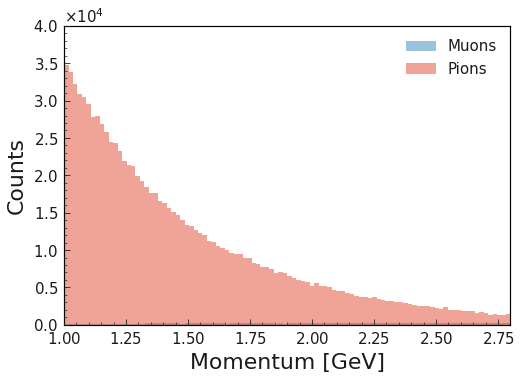

In [7]:
# Histograms

muon_hist = plt.hist(muon_dataset["Momentum"], label = "Muons", bins = 100, alpha = 0.5)
pion_hist = plt.hist(pion_dataset["Momentum"], label = "Pions", bins = 100, alpha = 0.5)

plt.xlabel("Momentum [GeV]")
plt.ylabel("Counts")
plt.xlim((1, 2.8))

plt.legend()

print("Pions = ", pion_dataset.shape[0], "\nMuons = ", muon_dataset.shape[0])

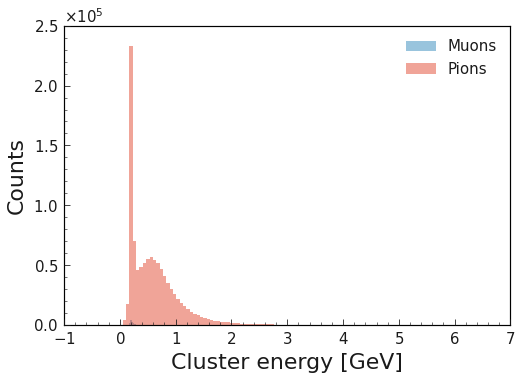

In [8]:
plt.hist(muon_dataset["ClusterE"], label = "Muons", bins = 100, alpha = 0.5)
plt.hist(pion_dataset["ClusterE"], label = "Pions", bins = 100, alpha = 0.5)

plt.xlabel("Cluster energy [GeV]")
plt.ylabel("Counts")
#plt.xlim((0,1))

plt.legend()

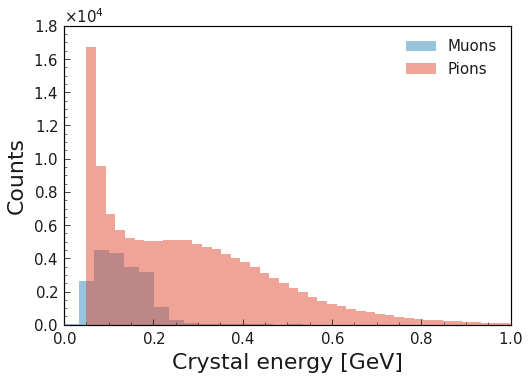

In [9]:
muon_dataset2 = muon_dataset[muon_dataset["OnlineEnergy"] > .05]
pion_dataset2 = pion_dataset[np.logical_and(pion_dataset["OfflineHadronIntensity"] > .08, pion_dataset["OnlineEnergy"] > .05)]


plt.hist(muon_dataset["OnlineEnergy"], label = "Muons", bins = 100, alpha = 0.5)
plt.hist(pion_dataset2["OnlineEnergy"], label = "Pions", bins = 100, alpha = 0.5)

plt.xlabel("Crystal energy [GeV]")
plt.ylabel("Counts")
plt.xlim((0,1))

plt.legend()

/cvmfs/belle.cern.ch/el7/externals/v01-09-01/Linux_x86_64/common/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/cvmfs/belle.cern.ch/el7/externals/v01-09-01/Linux_x86_64/common/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


Text(0, 0.5, 'Ratio')

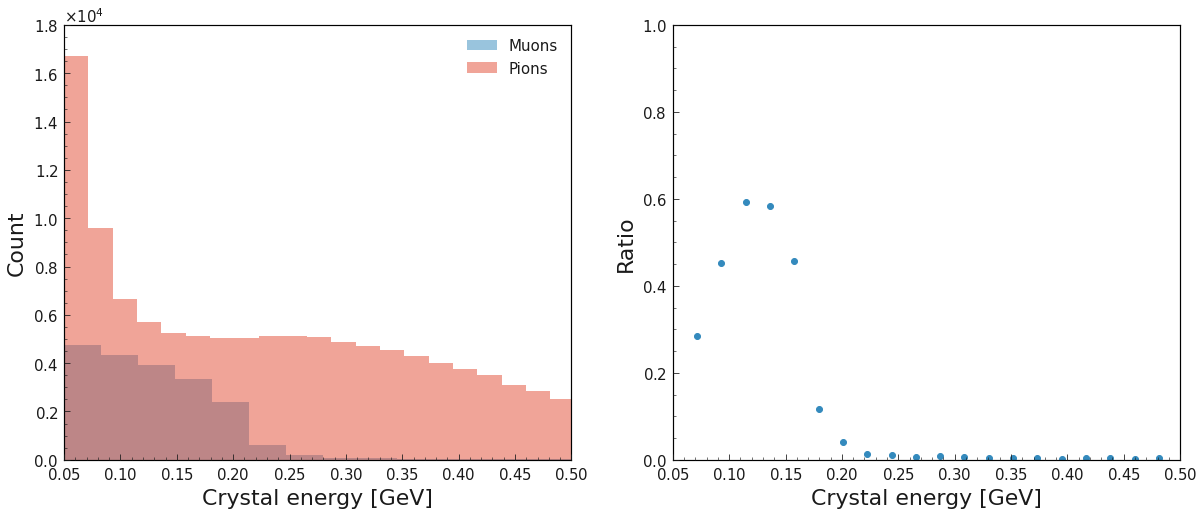

In [10]:
# OnlineEnergy ratio

plt.figure(figsize=(20,8))

plt.subplot(1,2,1)
muon_hist = plt.hist(muon_dataset2["OnlineEnergy"], label = "Muons", bins = 100, alpha = 0.5)
pion_hist = plt.hist(pion_dataset2["OnlineEnergy"], label = "Pions", bins = 100, alpha = 0.5)

hist_ratio = muon_hist[0]/pion_hist[0]

plt.xlabel("Crystal energy [GeV]")
plt.ylabel("Count")

plt.xlim((.05, .5))

plt.legend()


plt.subplot(1,2,2)
plt.scatter(pion_hist[1][1:], hist_ratio)

plt.xlim((.05,.5))
plt.ylim((0,1))

plt.xlabel("Crystal energy [GeV]")
plt.ylabel("Ratio")

In [11]:
muon_dataset3 = muon_dataset2[muon_dataset["OnlineEnergy"] < .5]
pion_dataset3 = pion_dataset2[pion_dataset["OnlineEnergy"] < .5]

/cvmfs/belle.cern.ch/el7/externals/v01-09-01/Linux_x86_64/common/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
/cvmfs/belle.cern.ch/el7/externals/v01-09-01/Linux_x86_64/common/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [12]:
muon_hist = plt.hist(muon_dataset3["OnlineEnergy"], label = "Muons", bins = 100, alpha = 0.5)
plt.clf()

pion_hist = plt.hist(pion_dataset3["OnlineEnergy"], label = "Pions", bins = 100, alpha = 0.5)
plt.clf()

hist_ratio = muon_hist[0]/pion_hist[0]

<Figure size 576x396 with 0 Axes>

In [13]:
pion_dataset3["r"] = np.random.uniform(0, 1, pion_dataset3.shape[0])
pion_dataset4 = pion_dataset3.iloc[np.where(pion_dataset3["r"] < hist_ratio[np.digitize(pion_dataset3["OnlineEnergy"], pion_hist[1][1:], right=True)])]

pion_dataset3.drop("r", axis=1, inplace=True)

/cvmfs/belle.cern.ch/el7/externals/v01-09-01/Linux_x86_64/common/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/cvmfs/belle.cern.ch/el7/externals/v01-09-01/Linux_x86_64/common/lib/python3.6/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


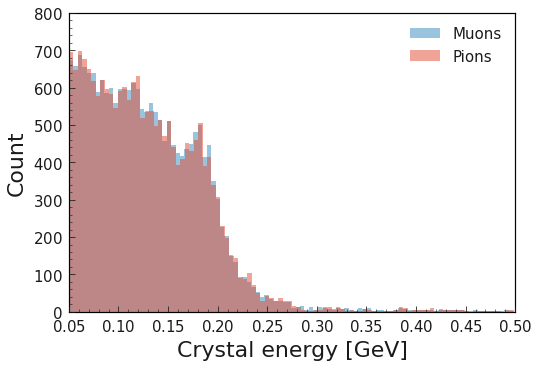

In [14]:
plt.hist(muon_dataset3["OnlineEnergy"], label = "Muons", bins = 100, alpha = 0.5)
plt.hist(pion_dataset4["OnlineEnergy"], label = "Pions", bins = 100, alpha = 0.5)

plt.xlabel("Crystal energy [GeV]")
plt.ylabel("Count")
plt.xlim((.05, .5))

plt.legend()

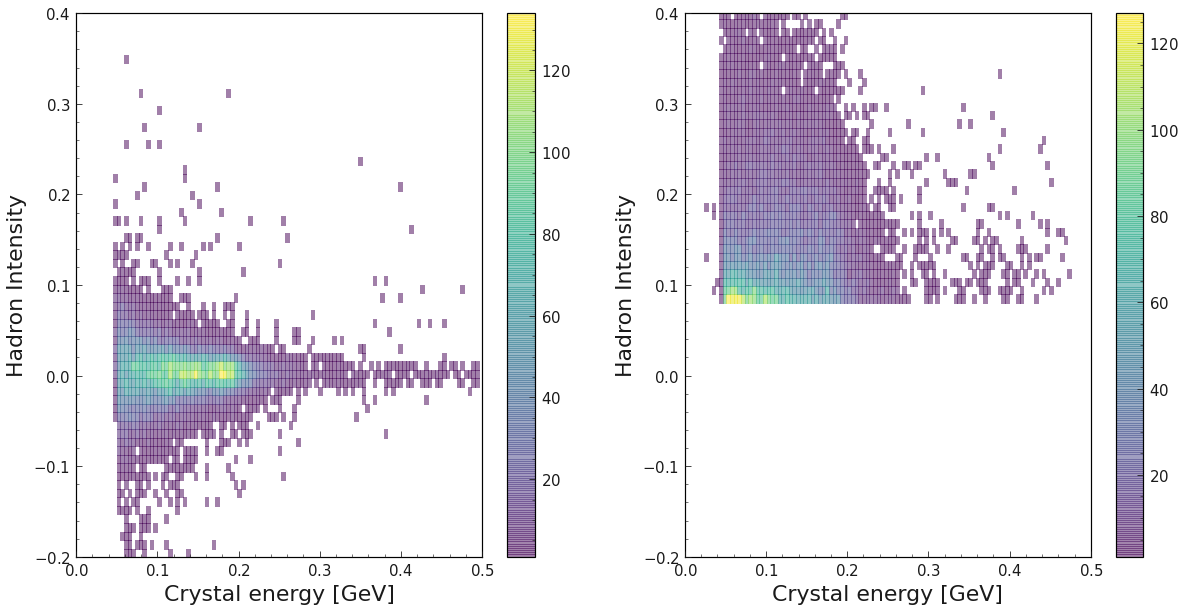

In [15]:
plt.figure(figsize=(20,10))

plt.subplot(1,2,1)
plt.hist2d(muon_dataset3["OfflineEnergy"], muon_dataset3["OfflineHadronIntensity"], label = "Muons", bins = 100, alpha = 0.5, cmin=1)

plt.xlim((0,.5))
plt.ylim((-.2, .4))
plt.xlabel("Crystal energy [GeV]")
plt.ylabel("Hadron Intensity")

plt.colorbar()


plt.subplot(1,2,2)
plt.hist2d(pion_dataset4["OfflineEnergy"], pion_dataset4["OfflineHadronIntensity"], label = "Pions", bins = 100, alpha = 0.5, cmin=1)

plt.xlim((0,.5))
plt.ylim((-.2, .4))
plt.xlabel("Crystal energy [GeV]")
plt.ylabel("Hadron Intensity")

plt.colorbar()

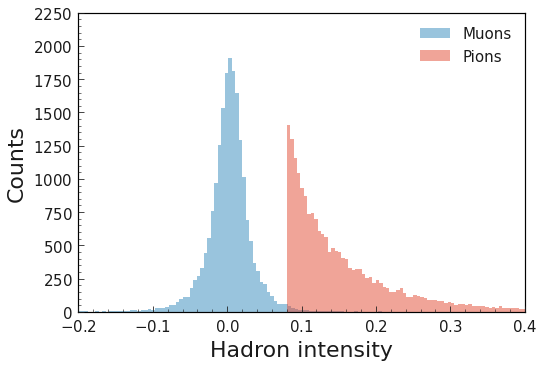

In [16]:
plt.hist(muon_dataset3["OfflineHadronIntensity"], alpha=0.5, bins=200, label="Muons")
plt.hist(pion_dataset4["OfflineHadronIntensity"], alpha=0.5, bins=200, label="Pions")

plt.xlim((-.2, .4))
plt.xlabel("Hadron intensity")
plt.ylabel("Counts")

plt.legend()

In [17]:
print("Number of muons = {}\nNumber of pions = {}".format(muon_dataset3.shape[0], pion_dataset4.shape[0]))

Number of muons = 19839
Number of pions = 19655


Text(0, 0.5, 'Counts')

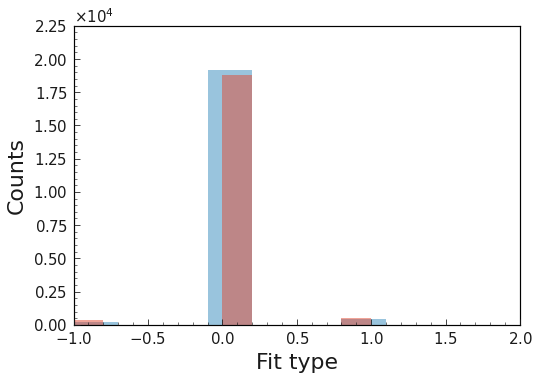

In [18]:
plt.hist(muon_dataset3["Fittype"], alpha=0.5, bins=10)
plt.hist(pion_dataset4["Fittype"], alpha=0.5, bins=10)

plt.xlim((-1, 2))
plt.xlabel("Fit type")
plt.ylabel("Counts")

# Training/Test set 

In [3]:
waveform_columns = ['ADC0', 'ADC1', 'ADC2', 'ADC3', 'ADC4', 'ADC5', 'ADC6', 'ADC7', 'ADC8', 'ADC9', 'ADC10', 'ADC11', 'ADC12', 'ADC13', 'ADC14', 'ADC15', 'ADC16', 'ADC17', 'ADC18', 'ADC19', 'ADC20', 'ADC21', 'ADC22', 'ADC23', 'ADC24', 'ADC25', 'ADC26', 'ADC27', 'ADC28', 'ADC29', 'ADC30']
output_columns = ['Particle']
norm = 262143

In [20]:
dataset = pd.concat([muon_dataset3, pion_dataset4], ignore_index=True)
dataset = dataset.sample(frac = 1)

train_df, test_df = train_test_split(dataset, test_size = .2, stratify = dataset["Particle"])

#we need to normalize the ADC counts to be in range of 0 and 1 and we do this by dividing by this factor
train_x = np.stack([train_df[col].div(norm).values for col in waveform_columns], 1) #divide by 262143 for the normalization
test_x = np.stack([test_df[col].div(norm).values for col in waveform_columns], 1)

# CONVOLUTIONAL NETWORK ONLY:
train_x = train_x.reshape(train_x.shape[0], 31, 1)
test_x = test_x.reshape(test_x.shape[0], 31, 1)


train_y = np.stack([train_df[col].values for col in output_columns], 1)
test_y = np.stack([test_df[col].values for col in output_columns], 1)

<br>

# Model

In [21]:
# DENSE NETWORK

# inputs = keras.layers.Input(shape = (31,))

# x = keras.layers.Dense(128, activation="relu")(inputs)
# x = keras.layers.Dense(128, activation="relu")(x)

# CONVOLUTIONAL NETWORK

inputs = keras.layers.Input(shape = (31,1))

x = keras.layers.Conv1D(32, kernel_size = 7, activation="tanh")(inputs)
x = keras.layers.Conv1D(64, kernel_size = 5, activation="tanh")(x)
x = keras.layers.Flatten()(x)

x = keras.layers.Dense(64, activation="relu")(x)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.Dense(64, activation="relu")(x)

outputs = keras.layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs = inputs, outputs = outputs, name="DNN")

model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "DNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 31, 1)             0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 25, 32)            256       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 21, 64)            10304     
_________________________________________________________________
flatten_1 (Flatten)          (None, 1344)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                86080     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
________________________________________________

In [22]:
EPOCH = 1500
BATCH_SIZE = 32
LR = 1e-3

model.compile(optimizer = keras.optimizers.Adam(learning_rate = LR),
             loss = "binary_crossentropy",
             metrics = ["accuracy"])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [23]:
filepath = "./CNN_PulseShapeCut_var1_{}".format(datetime.now().strftime("%d-%m-%Y-%H:%M:%S"))

model_ckpt = keras.callbacks.ModelCheckpoint(
    filepath,
    monitor="val_accuracy",
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)

reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.1,
                              patience=100, min_lr=1e-6,
                              min_delta=0.005, verbose=1)

callbacks = [model_ckpt, reduce_lr]


# DNN command:
history = model.fit(train_x, train_y, validation_split = 0.2,
                 epochs = EPOCH, batch_size = BATCH_SIZE, callbacks = callbacks)


Train on 25276 samples, validate on 6319 samples
Epoch 1/1500
25276/25276 [==============================] - 5s 182us/step - loss: 0.6937 - accuracy: 0.5013 - val_loss: 0.6931 - val_accuracy: 0.4923

Epoch 00001: val_accuracy improved from -inf to 0.49232, saving model to ./CNN_PulseShapeCut_var1_23-08-2021-12:46:49
Epoch 2/1500
25276/25276 [==============================] - 3s 133us/step - loss: 0.6887 - accuracy: 0.5319 - val_loss: 0.6764 - val_accuracy: 0.5762

Epoch 00002: val_accuracy improved from 0.49232 to 0.57620, saving model to ./CNN_PulseShapeCut_var1_23-08-2021-12:46:49
Epoch 3/1500
25276/25276 [==============================] - 3s 136us/step - loss: 0.5230 - accuracy: 0.7279 - val_loss: 0.3621 - val_accuracy: 0.8517

Epoch 00003: val_accuracy improved from 0.57620 to 0.85172, saving model to ./CNN_PulseShapeCut_var1_23-08-2021-12:46:49
Epoch 4/1500
25276/25276 [==============================] - 3s 135us/step - loss: 0.3667 - accuracy: 0.8533 - val_loss: 0.3174 - val_accu

In [24]:
print(filepath)
# model = keras.models.load_model(filepath)

./CNN_PulseShapeCut_var1_23-08-2021-12:46:49


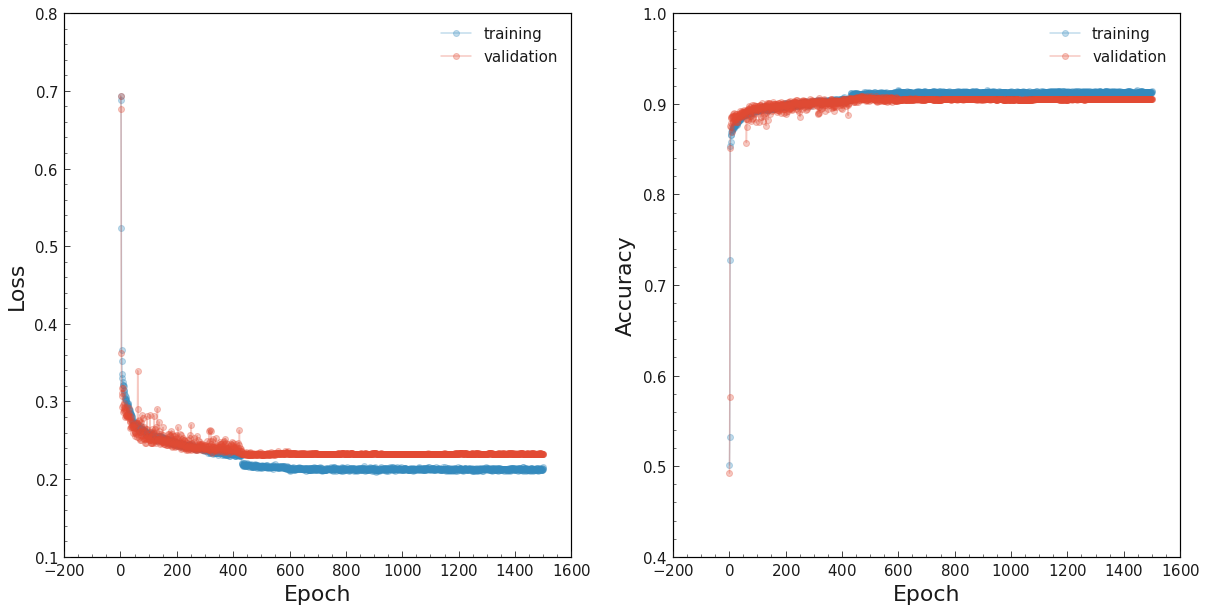

In [58]:
plt.figure(figsize = (20,10)) 

plt.subplot(1,2,1)
plt.plot(np.arange(len(history.history["loss"])) + 1, history.history["loss"], "-o", label = 'training', alpha=0.3)
plt.plot(np.arange(len(history.history["loss"])) + 1, history.history["val_loss"], "-o", label = 'validation', alpha=0.3)

plt.xlabel('Epoch')
plt.ylabel('Loss')

legend = plt.legend()

plt.subplot(1,2,2)
plt.plot(np.arange(len(history.history["loss"])) + 1, history.history["accuracy"],"-o", label = 'training', alpha=0.3)
plt.plot(np.arange(len(history.history["loss"])) + 1, history.history["val_accuracy"],"-o", label = 'validation', alpha=0.3)

plt.xlabel('Epoch')
plt.ylabel('Accuracy')

legend = plt.legend()

plt.savefig("./figures/CNN_loss_acc.pdf")

In [26]:
# Final model:
print("Test accuracy = ", model.evaluate(test_x, test_y)[1])

7899/7899 [==============================] - 0s 37us/step
Test accuracy =  0.9073300361633301


In [52]:
# Best model (loaded):
modeltmp = keras.models.load_model(filepath)
print("Test accuracy = ", modeltmp.evaluate(test_x, test_y)[1])

7899/7899 [==============================] - 1s 64us/step
Test accuracy =  0.9091024398803711


<br>

## Post-training plots

In [27]:
test_muons = test_x[np.where(test_y == 1)[0]] 
test_pions = test_x[np.where(test_y == 0)[0]] 

preds_muons = model.predict(test_muons)
preds_pions = model.predict(test_pions)

print("Muons: ", preds_muons)
print("Pions: ", preds_pions)

Muons:  [[0.9860313 ]
 [0.78651834]
 [0.68622255]
 ...
 [0.9932331 ]
 [0.7559091 ]
 [0.7506306 ]]
Pions:  [[0.00748962]
 [0.00672695]
 [0.08649474]
 ...
 [0.7123781 ]
 [0.00423104]
 [0.01361163]]


### Network output

AUC =  0.9697070971229516


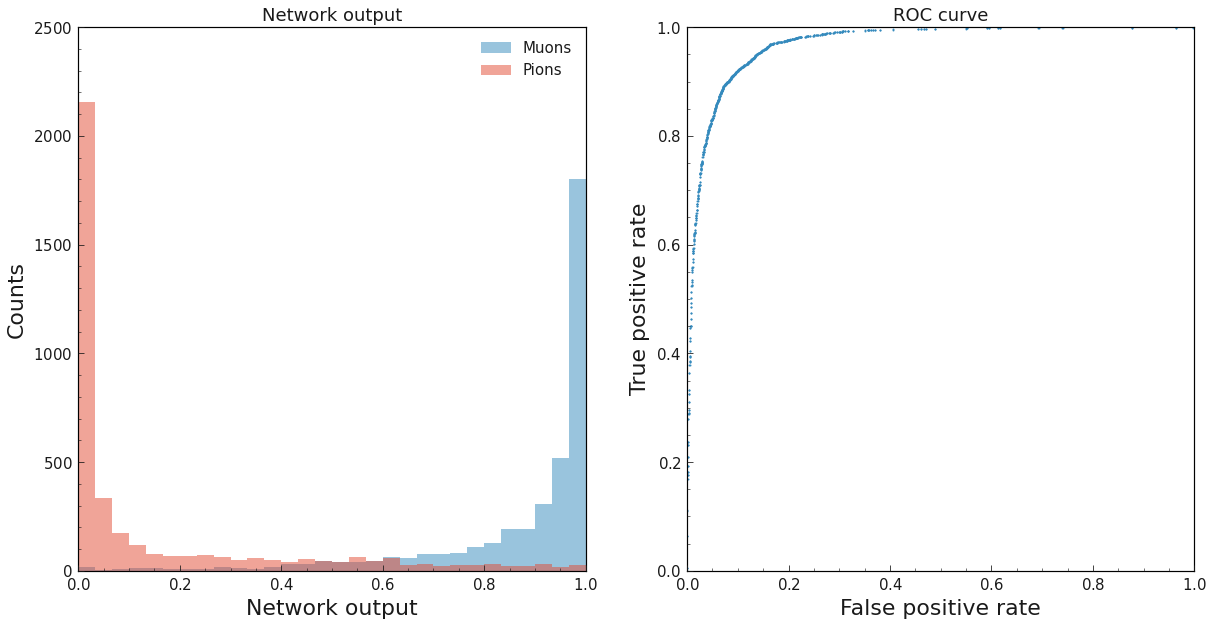

In [59]:
plt.figure(figsize=(20,10))

# Network output
plt.subplot(1,2,1)
plt.hist(preds_muons, bins = 30, alpha = 0.5, label = "Muons")
plt.hist(preds_pions, bins = 30, alpha = 0.5, label = "Pions")

plt.xlim((0,1))

plt.title("Network output")
plt.xlabel("Network output")
plt.ylabel("Counts")

plt.legend()


# ROC curve

# DENSE NETWORK
plt.subplot(1,2,2)
roc_out = roc_curve(test_y, model.predict(test_x))
print("AUC = ", roc_auc_score(test_y, model.predict(test_x)))
fpr, tpr = roc_out[0], roc_out[1]
plt.scatter(fpr, tpr, s=1, alpha=.9)


plt.xlim((0,1))
plt.ylim((0,1))

plt.title("ROC curve")
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")

plt.savefig("./figures/CNN_output_ROC.pdf")

In [29]:
liminf = 0.2
limsup = 0.8

# Region 1: network_ouput < liminf
pions_region1 = test_df[test_df["Particle"] == 0].iloc[np.where(preds_pions < liminf)[0]]
muons_region1 = test_df[test_df["Particle"] == 1].iloc[np.where(preds_muons < liminf)[0]]

# Region 2: liminf < network_ouput < limsup
pions_region2 = test_df[test_df["Particle"] == 0].iloc[np.where(np.logical_and(preds_pions > liminf, preds_pions < limsup))[0]]
muons_region2 = test_df[test_df["Particle"] == 1].iloc[np.where(np.logical_and(preds_muons > liminf, preds_muons < limsup))[0]]

# Region 3: network_ouput > limsup
pions_region3 = test_df[test_df["Particle"] == 0].iloc[np.where(preds_pions > limsup)[0]]
muons_region3 = test_df[test_df["Particle"] == 1].iloc[np.where(preds_muons > limsup)[0]]

## Particle variables:

In [30]:
def print_hist_efficiency(variable, range = None, unit="", bins=100):
    
    if unit != "":
        unit = "[" + unit + "]"
    
    if range == None:
        range = (min(test_df[variable]), max(test_df[variable]))
        
#      TODO: implement different binning for three regions (will need three different total hists for efficiency)
#     if type(bins) == int:
#         bins = [bins]*3
    
    plt.figure(figsize=(30,20))

    muon_hist, _ = np.histogram(test_df[test_df["Particle"] == 1][variable], bins=bins, range=range)
    pion_hist, _ = np.histogram(test_df[test_df["Particle"] == 0][variable], bins=bins, range=range)

    plt.subplot(2,3,1)
    muons_hist_region1, bins_x, _ = plt.hist(muons_region1[variable], bins = bins, alpha = 0.3, range=range, label = "Muons")
    pions_hist_region1, _, _ = plt.hist(pions_region1[variable], bins = bins, alpha = 0.3, range=range, label = "Pions")
    plt.xlabel(" ".join([variable, unit]))
    plt.ylabel("Counts")
    plt.title("Network output < " + str(liminf))
    plt.xlim(range)

    plt.legend()

    plt.subplot(2,3,2)
    muons_hist_region2, _, _ = plt.hist(muons_region2[variable], bins = bins, alpha = 0.3, range=range, label = "Muons")
    pions_hist_region2, _, _ =plt.hist(pions_region2[variable], bins = bins, alpha = 0.3, range=range, label = "Pions")
    plt.xlabel(" ".join([variable, unit]))
    plt.ylabel("Counts")
    plt.title(str(liminf) + " < Network output < " + str(limsup))
    plt.xlim(range)

    plt.legend()

    plt.subplot(2,3,3)
    muons_hist_region3, _, _ = plt.hist(muons_region3[variable], bins = bins, alpha = 0.3, range=range, label = "Muons")
    pions_hist_region3, _, _ = plt.hist(pions_region3[variable], bins = bins, alpha = 0.3, range=range, label = "Pions")
    plt.xlabel(" ".join([variable, unit]))
    plt.ylabel("Counts")
    plt.title("Network output > " + str(limsup))
    plt.xlim(range)

    plt.legend()

    bins_width = [bins_x[i+1] - bins_x[i] for i in np.arange(bins_x.shape[0])-1][1:]

    # TODO: implement efficiency on data points + uncertainties
    
    plt.subplot(2,3,4)
    plt.bar(bins_x[:-1], muons_hist_region1/muon_hist, width = bins_width, alpha = 0.3, label = "Muons")
    plt.bar(bins_x[:-1], pions_hist_region1/pion_hist, width = bins_width, alpha = 0.3, label = "Pions")
    plt.xlabel(" ".join([variable, unit]))
    plt.ylabel("Efficiency")
    plt.title("Network output < " + str(liminf))
    plt.xlim(range)

    plt.legend()

    plt.subplot(2,3,5)
    plt.bar(bins_x[:-1], muons_hist_region2/muon_hist, width = bins_width, alpha = 0.3, label = "Muons")
    plt.bar(bins_x[:-1], pions_hist_region2/pion_hist, width = bins_width, alpha = 0.3, label = "Pions")
    plt.xlabel(" ".join([variable, unit]))
    plt.ylabel("Efficiency")
    plt.title("{} < Network output < {}".format(liminf, limsup))
    plt.xlim(range)

    plt.legend()

    plt.subplot(2,3,6)
    plt.bar(bins_x[:-1], muons_hist_region3/muon_hist, width = bins_width, alpha = 0.3, label = "Muons")
    plt.bar(bins_x[:-1], pions_hist_region3/pion_hist, width = bins_width, alpha = 0.3, label = "Pions")
    plt.xlabel(" ".join([variable, unit]))
    plt.ylabel("Efficiency")
    plt.title("Network output > {}".format(limsup))
    plt.xlim(range)

    plt.legend()
    
    print("Count minimum in region 1 = {} (muons), {} (pions)\nCount minimum in region 2 = {} (muons), {} (pions)\nCount minimum in region 3 = {} (muons), {} (pions)".format(min(muons_hist_region1[muons_hist_region1 != 0], default=0), min(pions_hist_region1[pions_hist_region1 !=0], default=0), min(muons_hist_region2[muons_hist_region2 !=0], default=0), min(pions_hist_region2[pions_hist_region2 != 0], default=0), min(muons_hist_region3[muons_hist_region3 != 0], default=0), min(pions_hist_region3[ pions_hist_region3 != 0], default=0)))

### Momentum

Count minimum in region 1 = 1.0 (muons), 6.0 (pions)
Count minimum in region 2 = 9.0 (muons), 1.0 (pions)
Count minimum in region 3 = 22.0 (muons), 1.0 (pions)


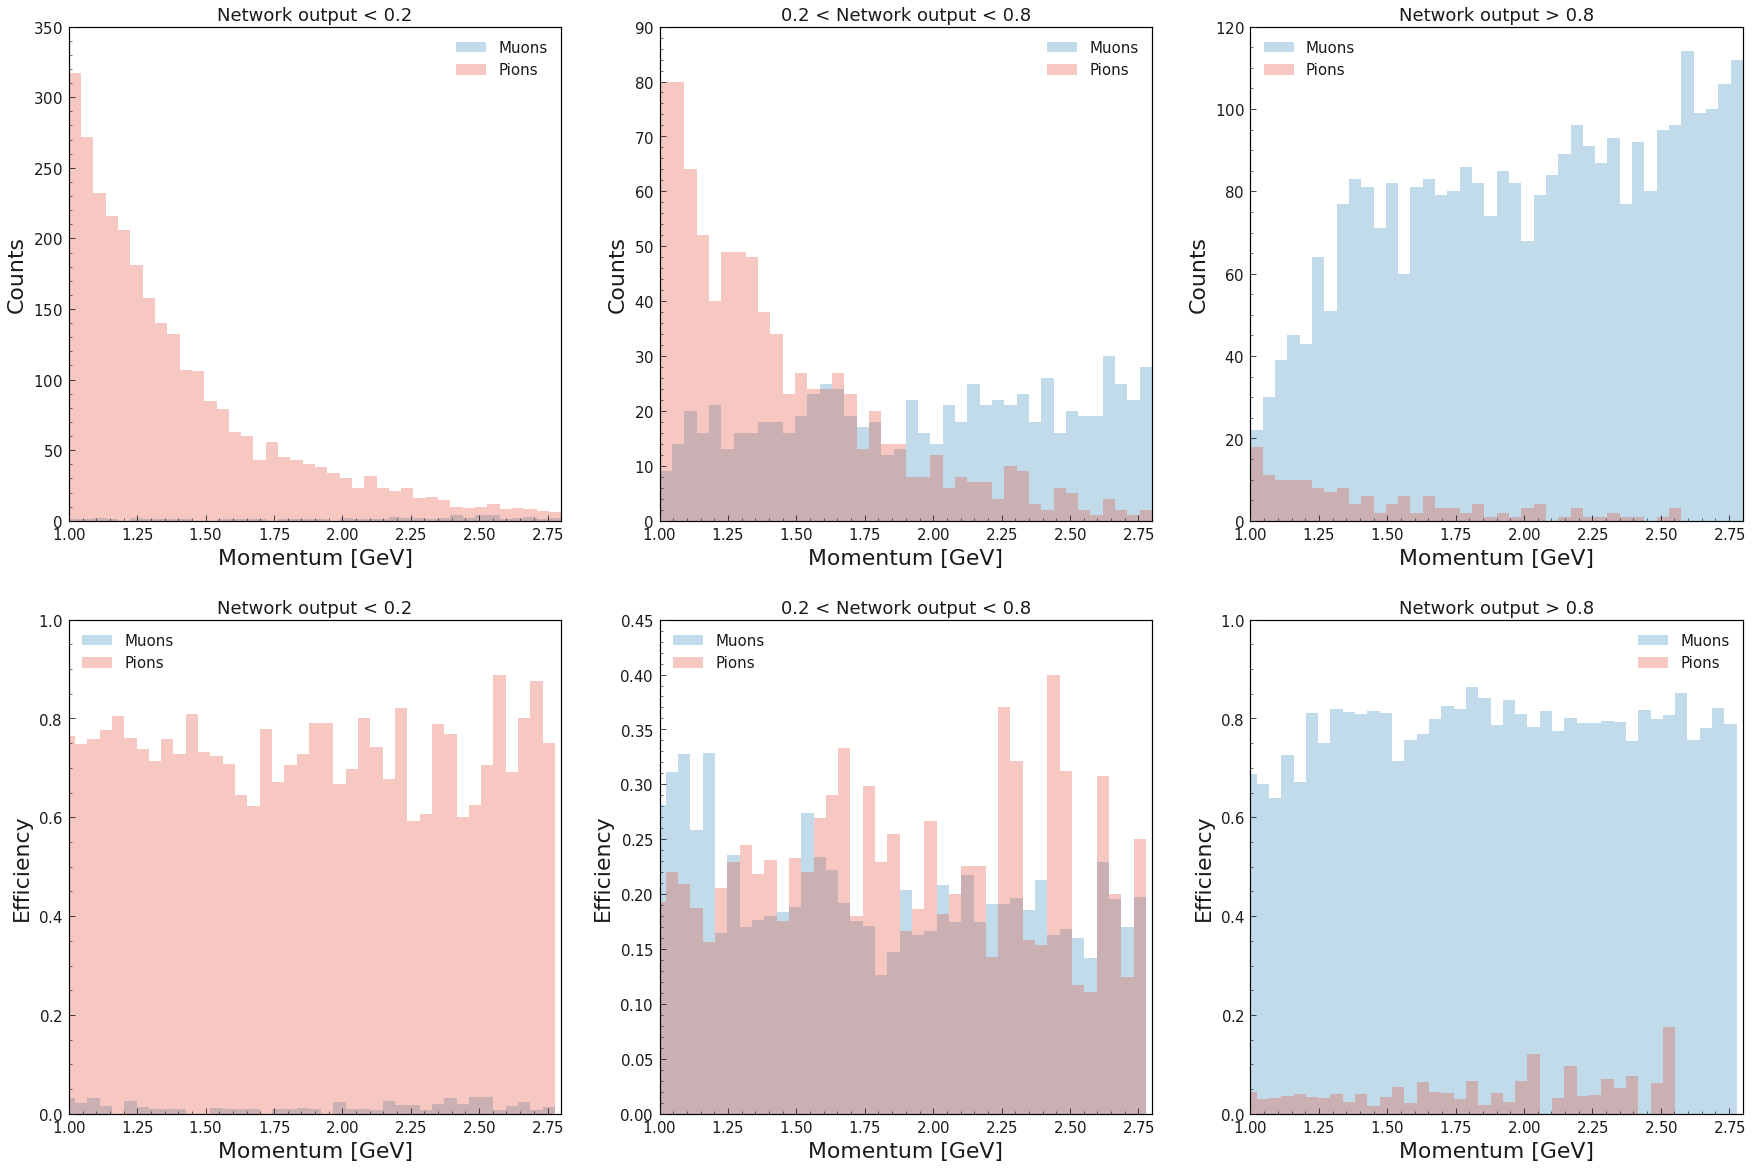

In [31]:
print_hist_efficiency("Momentum", range=(1, 2.8), unit="GeV", bins=40)

### Transerve momentum

/cvmfs/belle.cern.ch/el7/externals/v01-09-01/Linux_x86_64/common/lib/python3.6/site-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in true_divide
/cvmfs/belle.cern.ch/el7/externals/v01-09-01/Linux_x86_64/common/lib/python3.6/site-packages/ipykernel_launcher.py:62: RuntimeWarning: invalid value encountered in true_divide
/cvmfs/belle.cern.ch/el7/externals/v01-09-01/Linux_x86_64/common/lib/python3.6/site-packages/ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in true_divide


Count minimum in region 1 = 1.0 (muons), 1.0 (pions)
Count minimum in region 2 = 3.0 (muons), 1.0 (pions)
Count minimum in region 3 = 12.0 (muons), 1.0 (pions)


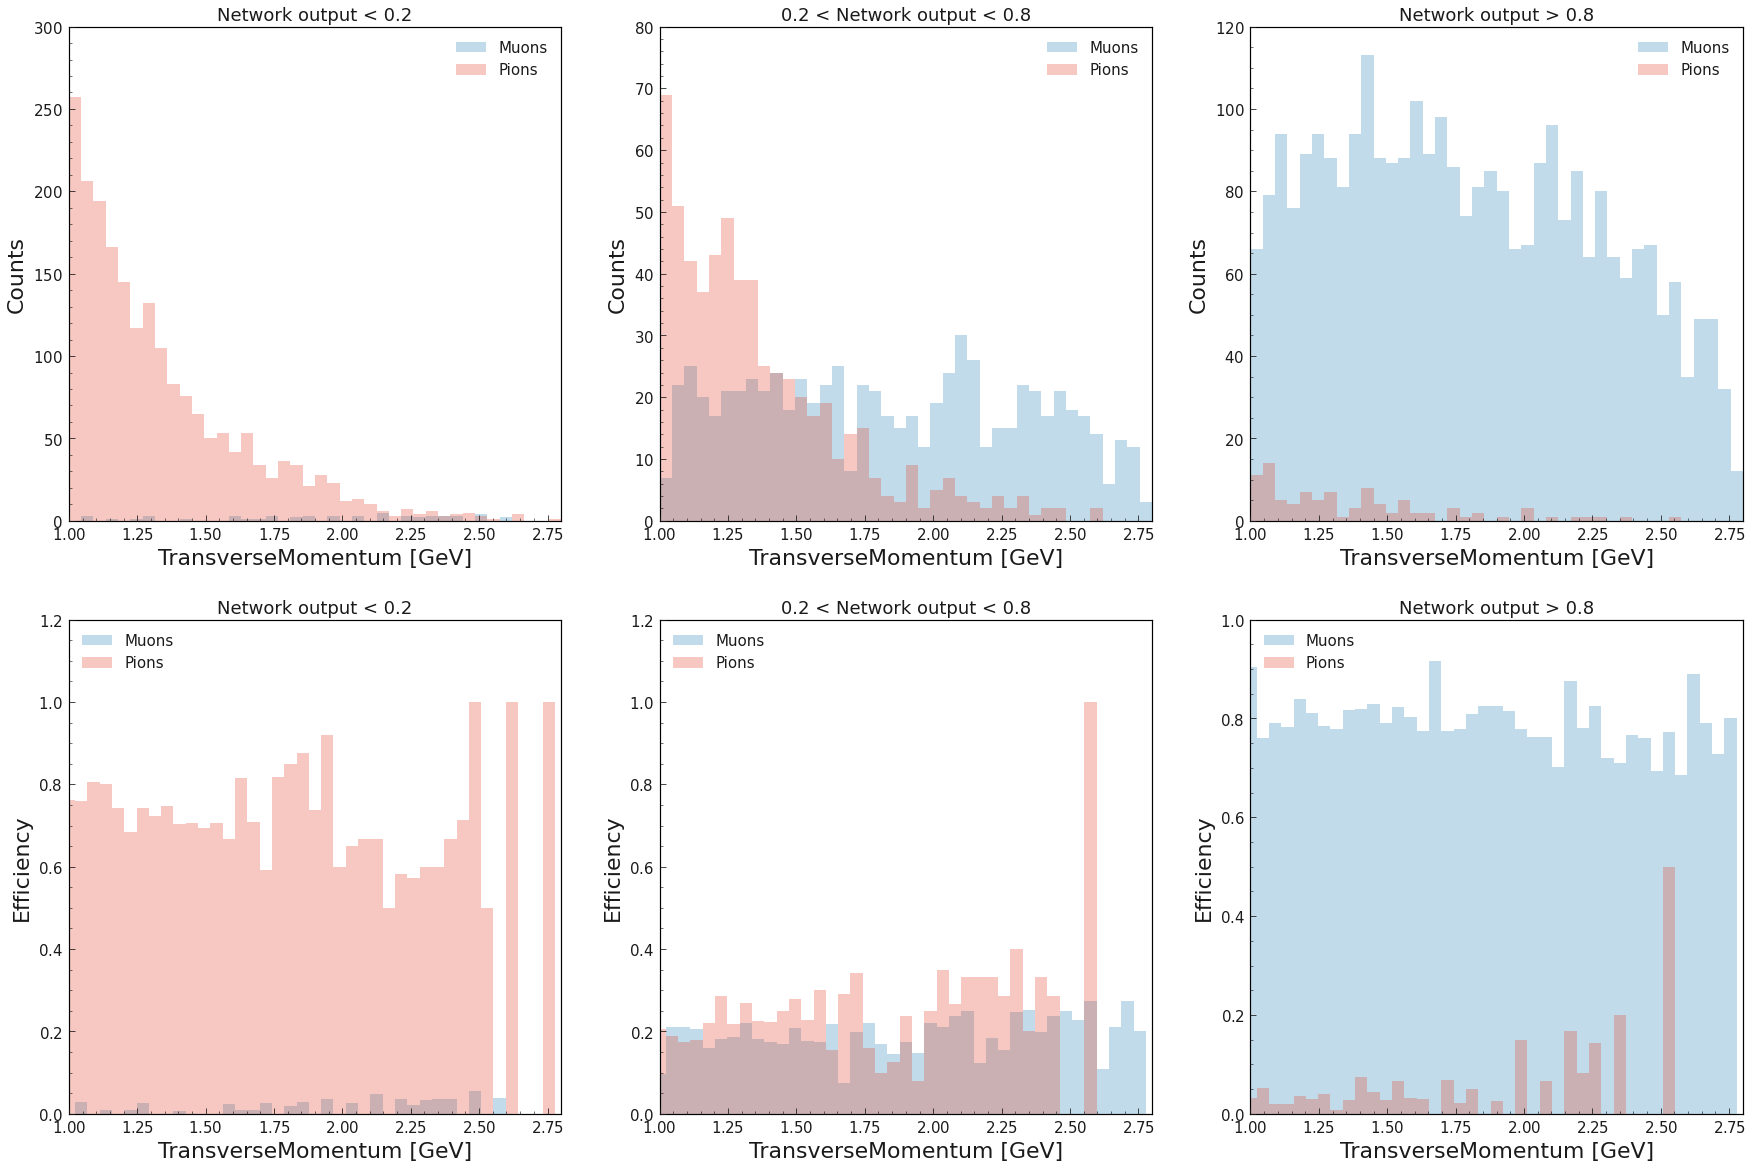

In [32]:
print_hist_efficiency("TransverseMomentum", range=(1, 2.8), unit="GeV", bins=40)

### Cluster energy

/cvmfs/belle.cern.ch/el7/externals/v01-09-01/Linux_x86_64/common/lib/python3.6/site-packages/ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in true_divide
/cvmfs/belle.cern.ch/el7/externals/v01-09-01/Linux_x86_64/common/lib/python3.6/site-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in true_divide
/cvmfs/belle.cern.ch/el7/externals/v01-09-01/Linux_x86_64/common/lib/python3.6/site-packages/ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in true_divide
/cvmfs/belle.cern.ch/el7/externals/v01-09-01/Linux_x86_64/common/lib/python3.6/site-packages/ipykernel_launcher.py:62: RuntimeWarning: invalid value encountered in true_divide
/cvmfs/belle.cern.ch/el7/externals/v01-09-01/Linux_x86_64/common/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: invalid value encountered in true_divide
/cvmfs/belle.cern.ch/el7/externals/v01-09-01/Linux_x86_64/common/lib/python3.6/site-packages/ipykernel_launcher.py:72: R

Count minimum in region 1 = 1.0 (muons), 1.0 (pions)
Count minimum in region 2 = 1.0 (muons), 1.0 (pions)
Count minimum in region 3 = 1.0 (muons), 1.0 (pions)


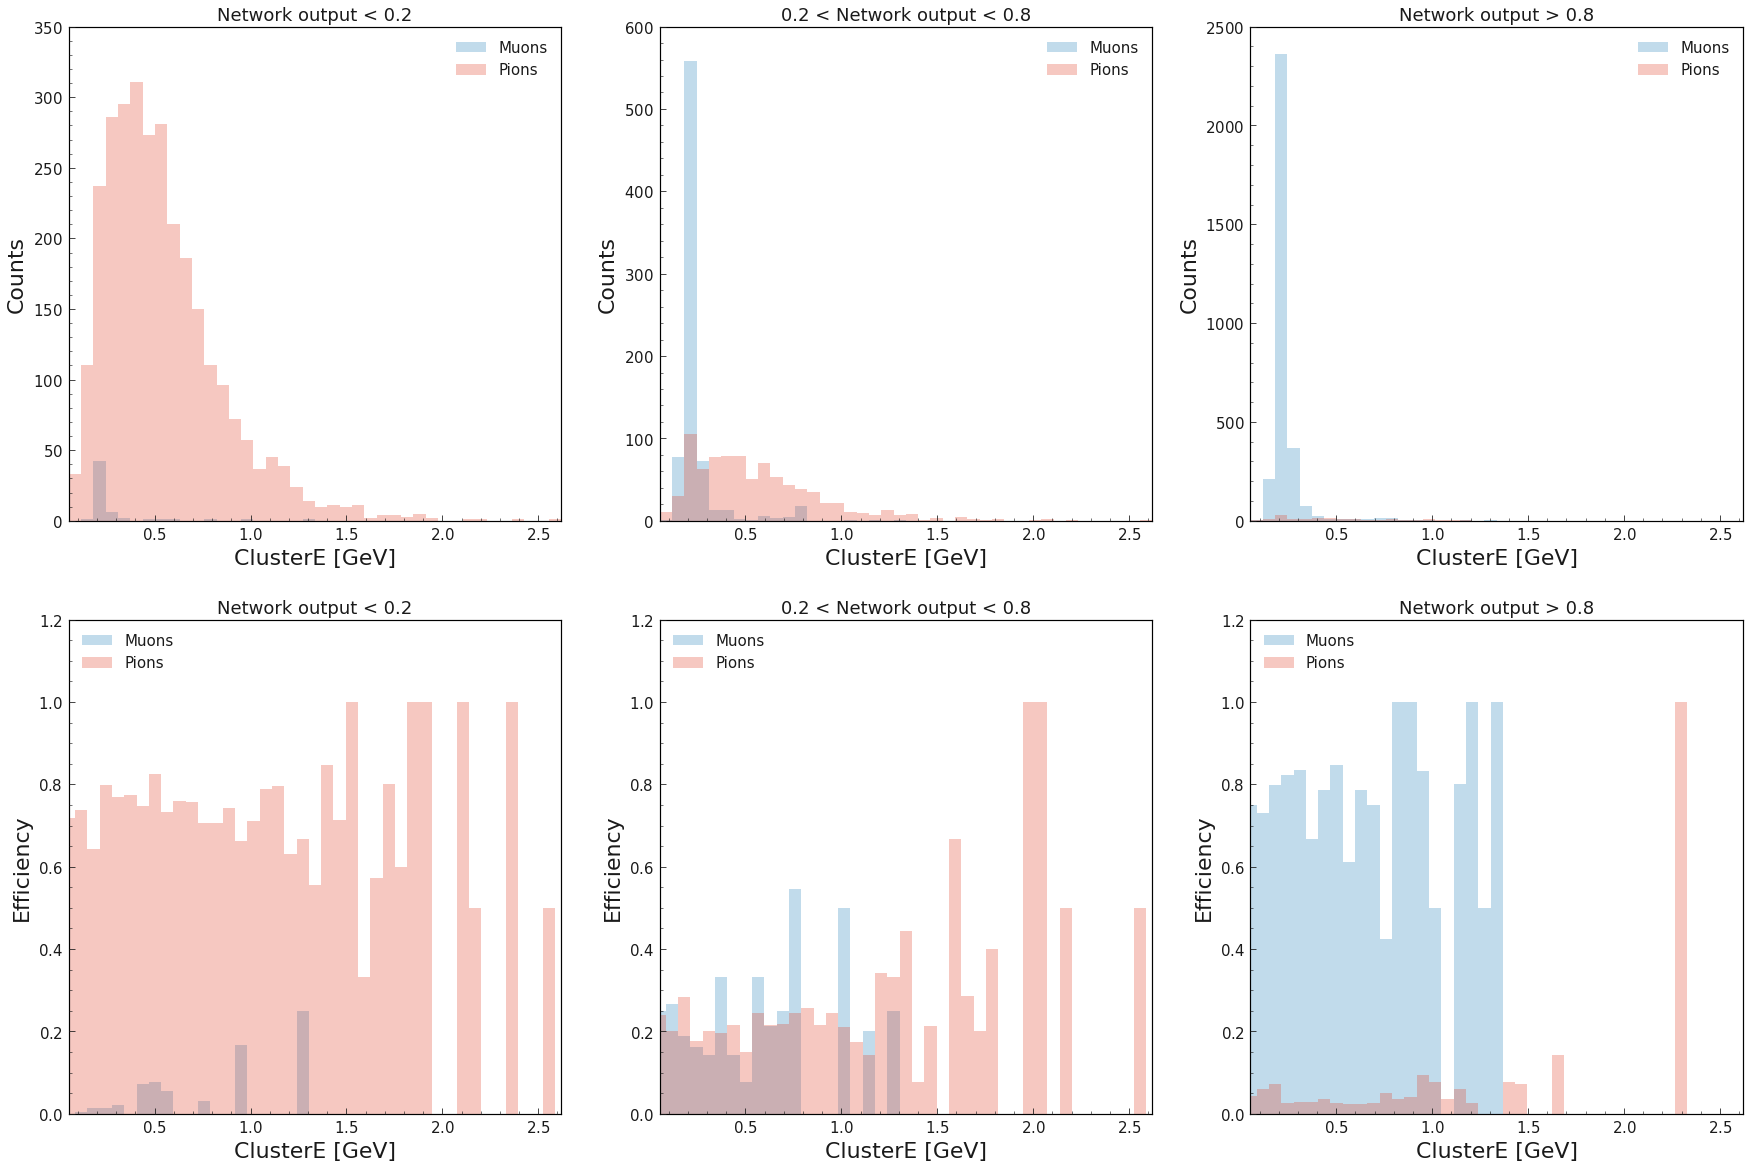

In [33]:
print_hist_efficiency("ClusterE", unit="GeV", bins=40)

### Cluster highest energy

/cvmfs/belle.cern.ch/el7/externals/v01-09-01/Linux_x86_64/common/lib/python3.6/site-packages/ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in true_divide
/cvmfs/belle.cern.ch/el7/externals/v01-09-01/Linux_x86_64/common/lib/python3.6/site-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in true_divide
/cvmfs/belle.cern.ch/el7/externals/v01-09-01/Linux_x86_64/common/lib/python3.6/site-packages/ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in true_divide
/cvmfs/belle.cern.ch/el7/externals/v01-09-01/Linux_x86_64/common/lib/python3.6/site-packages/ipykernel_launcher.py:62: RuntimeWarning: invalid value encountered in true_divide
/cvmfs/belle.cern.ch/el7/externals/v01-09-01/Linux_x86_64/common/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: invalid value encountered in true_divide
/cvmfs/belle.cern.ch/el7/externals/v01-09-01/Linux_x86_64/common/lib/python3.6/site-packages/ipykernel_launcher.py:72: R

Count minimum in region 1 = 1.0 (muons), 1.0 (pions)
Count minimum in region 2 = 1.0 (muons), 1.0 (pions)
Count minimum in region 3 = 1.0 (muons), 1.0 (pions)


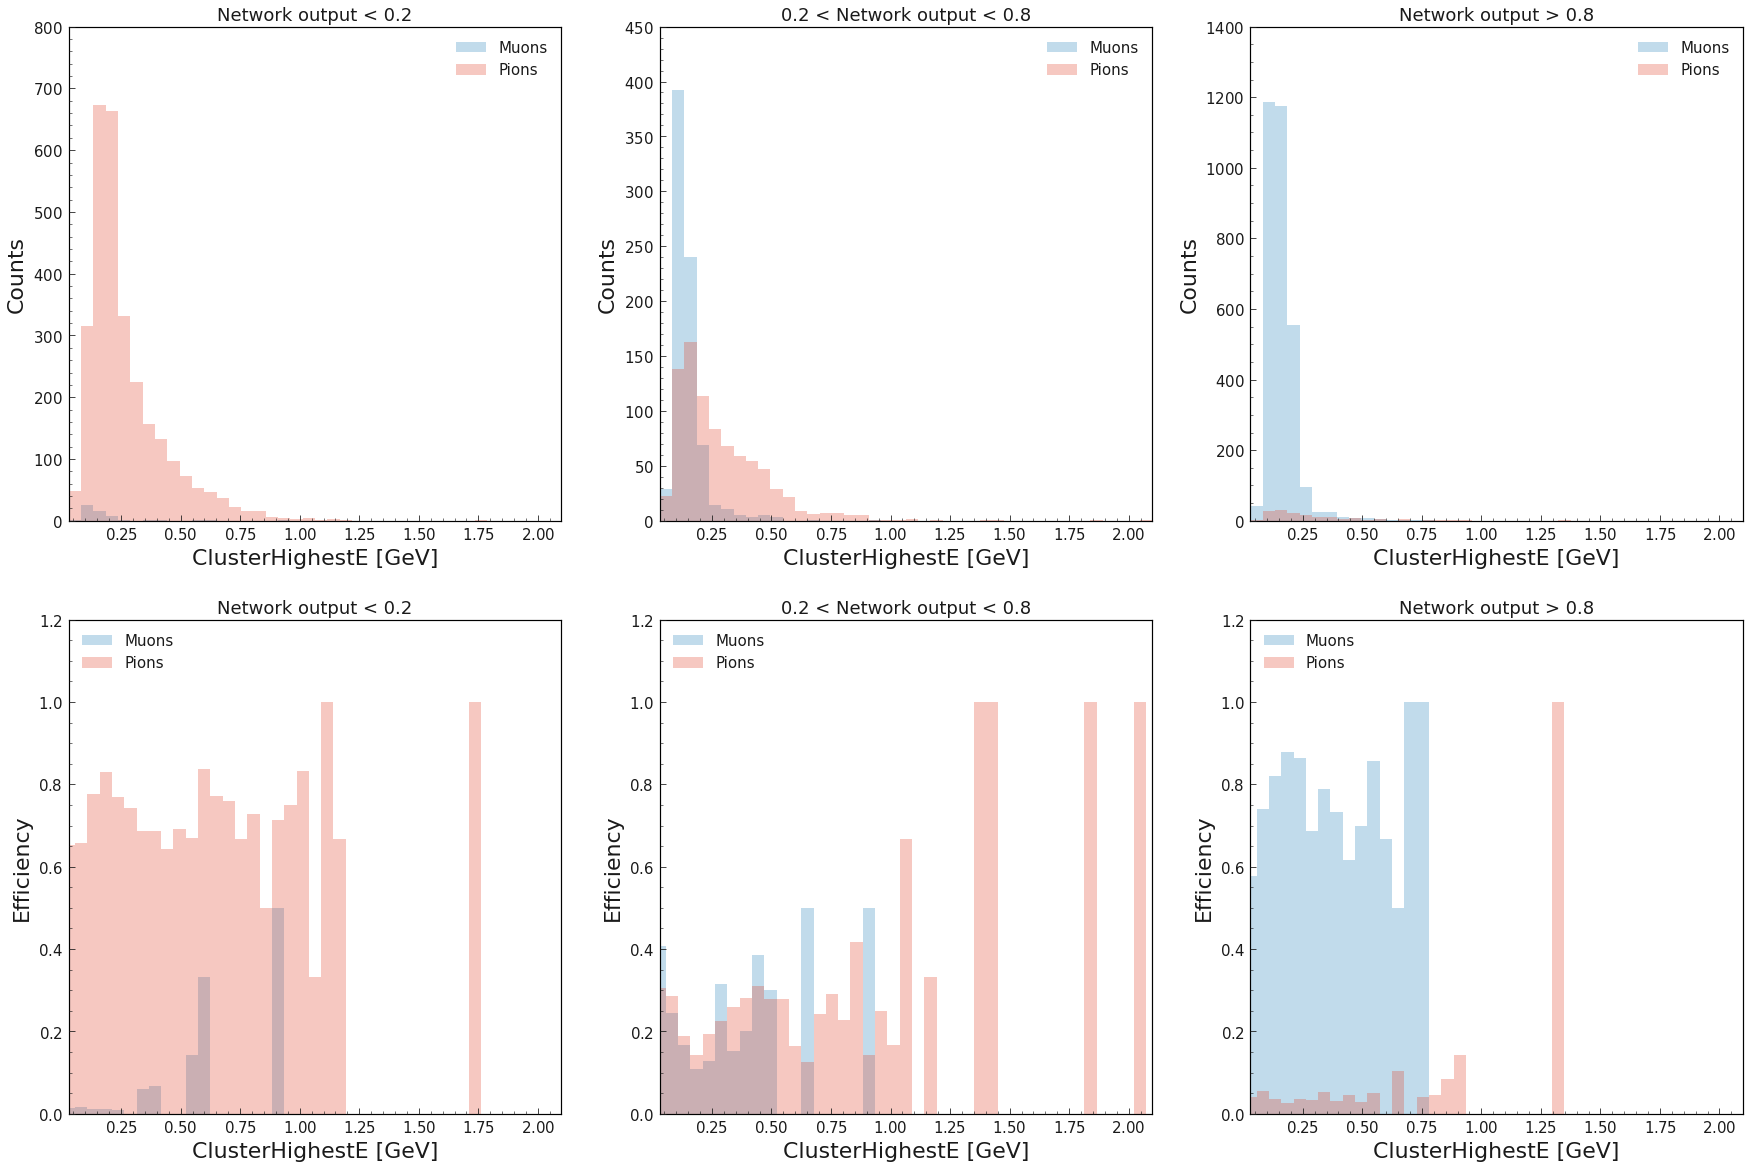

In [34]:
print_hist_efficiency("ClusterHighestE", unit="GeV", bins=40)

### Cluster $\theta$

Count minimum in region 1 = 1.0 (muons), 35.0 (pions)
Count minimum in region 2 = 5.0 (muons), 4.0 (pions)
Count minimum in region 3 = 43.0 (muons), 1.0 (pions)


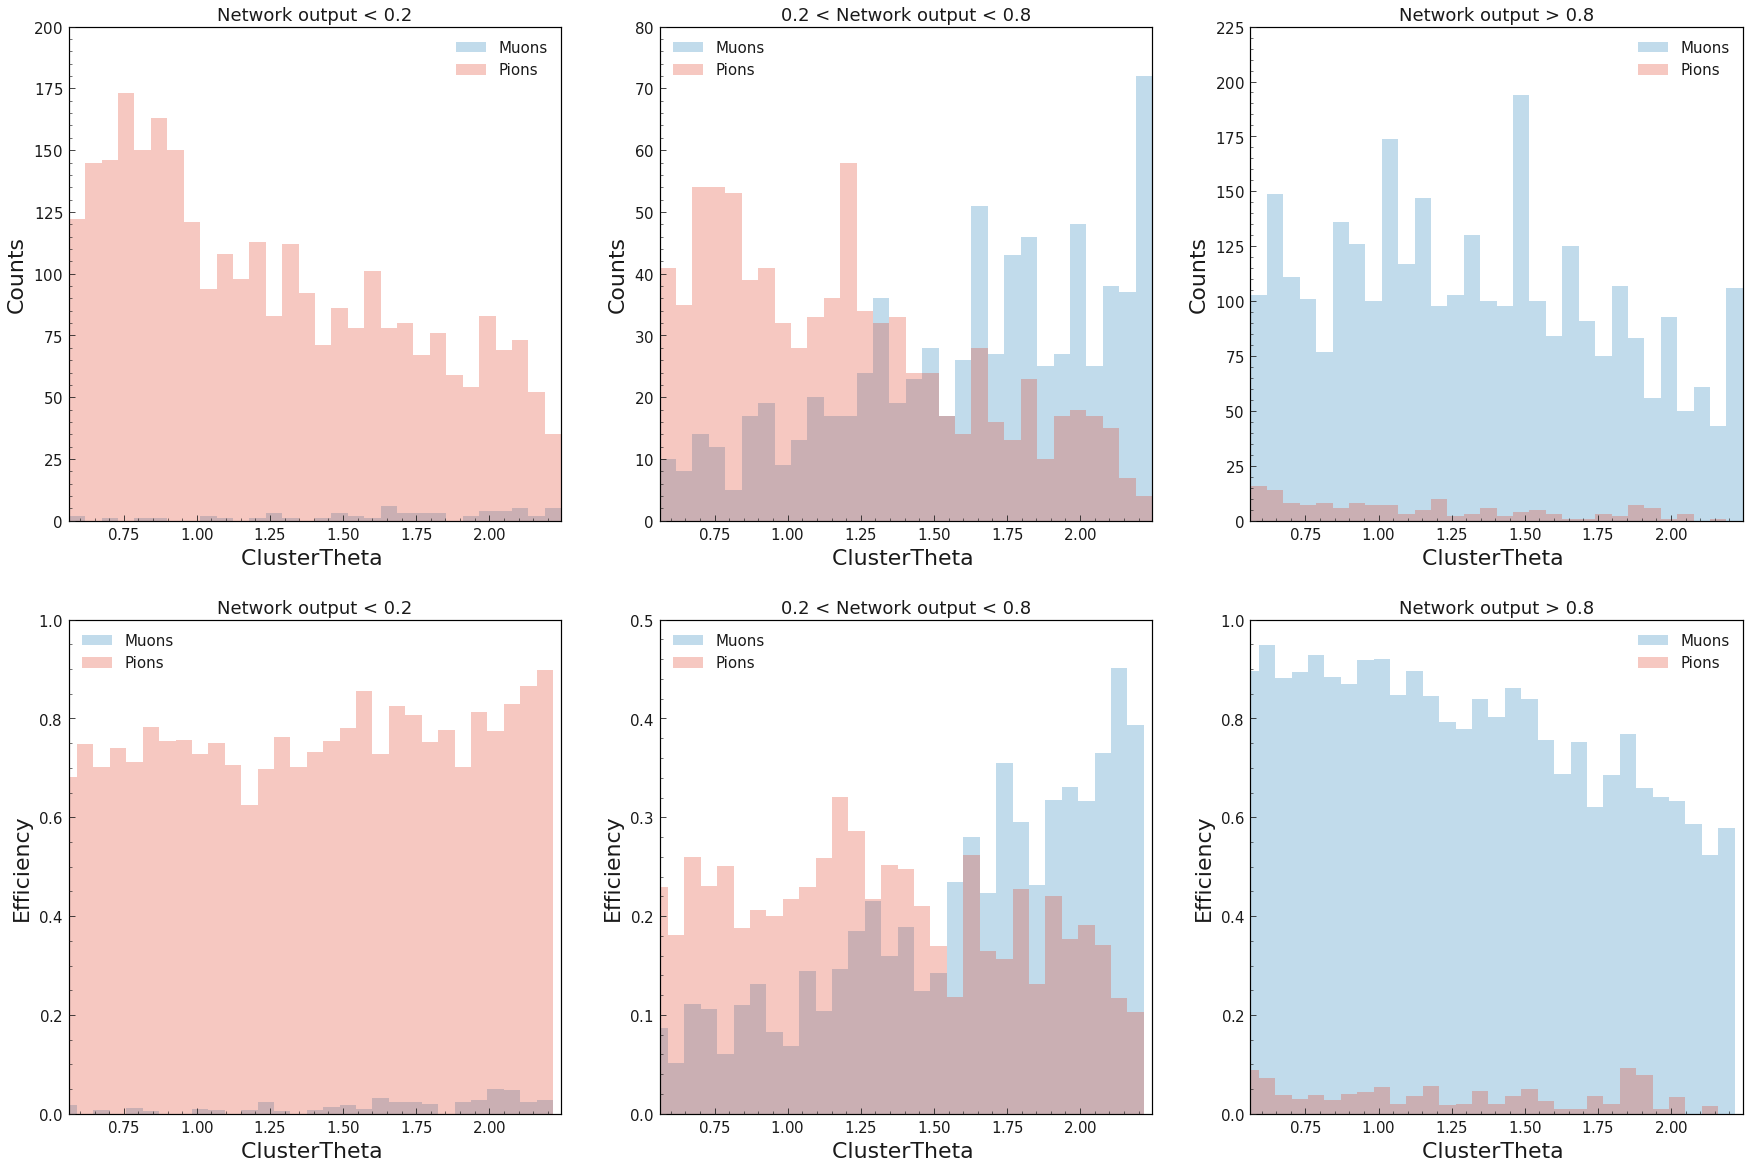

In [35]:
print_hist_efficiency("ClusterTheta", bins=30)

## Crystal variables

### CellID

Count minimum in region 1 = 1.0 (muons), 21.0 (pions)
Count minimum in region 2 = 5.0 (muons), 2.0 (pions)
Count minimum in region 3 = 38.0 (muons), 2.0 (pions)


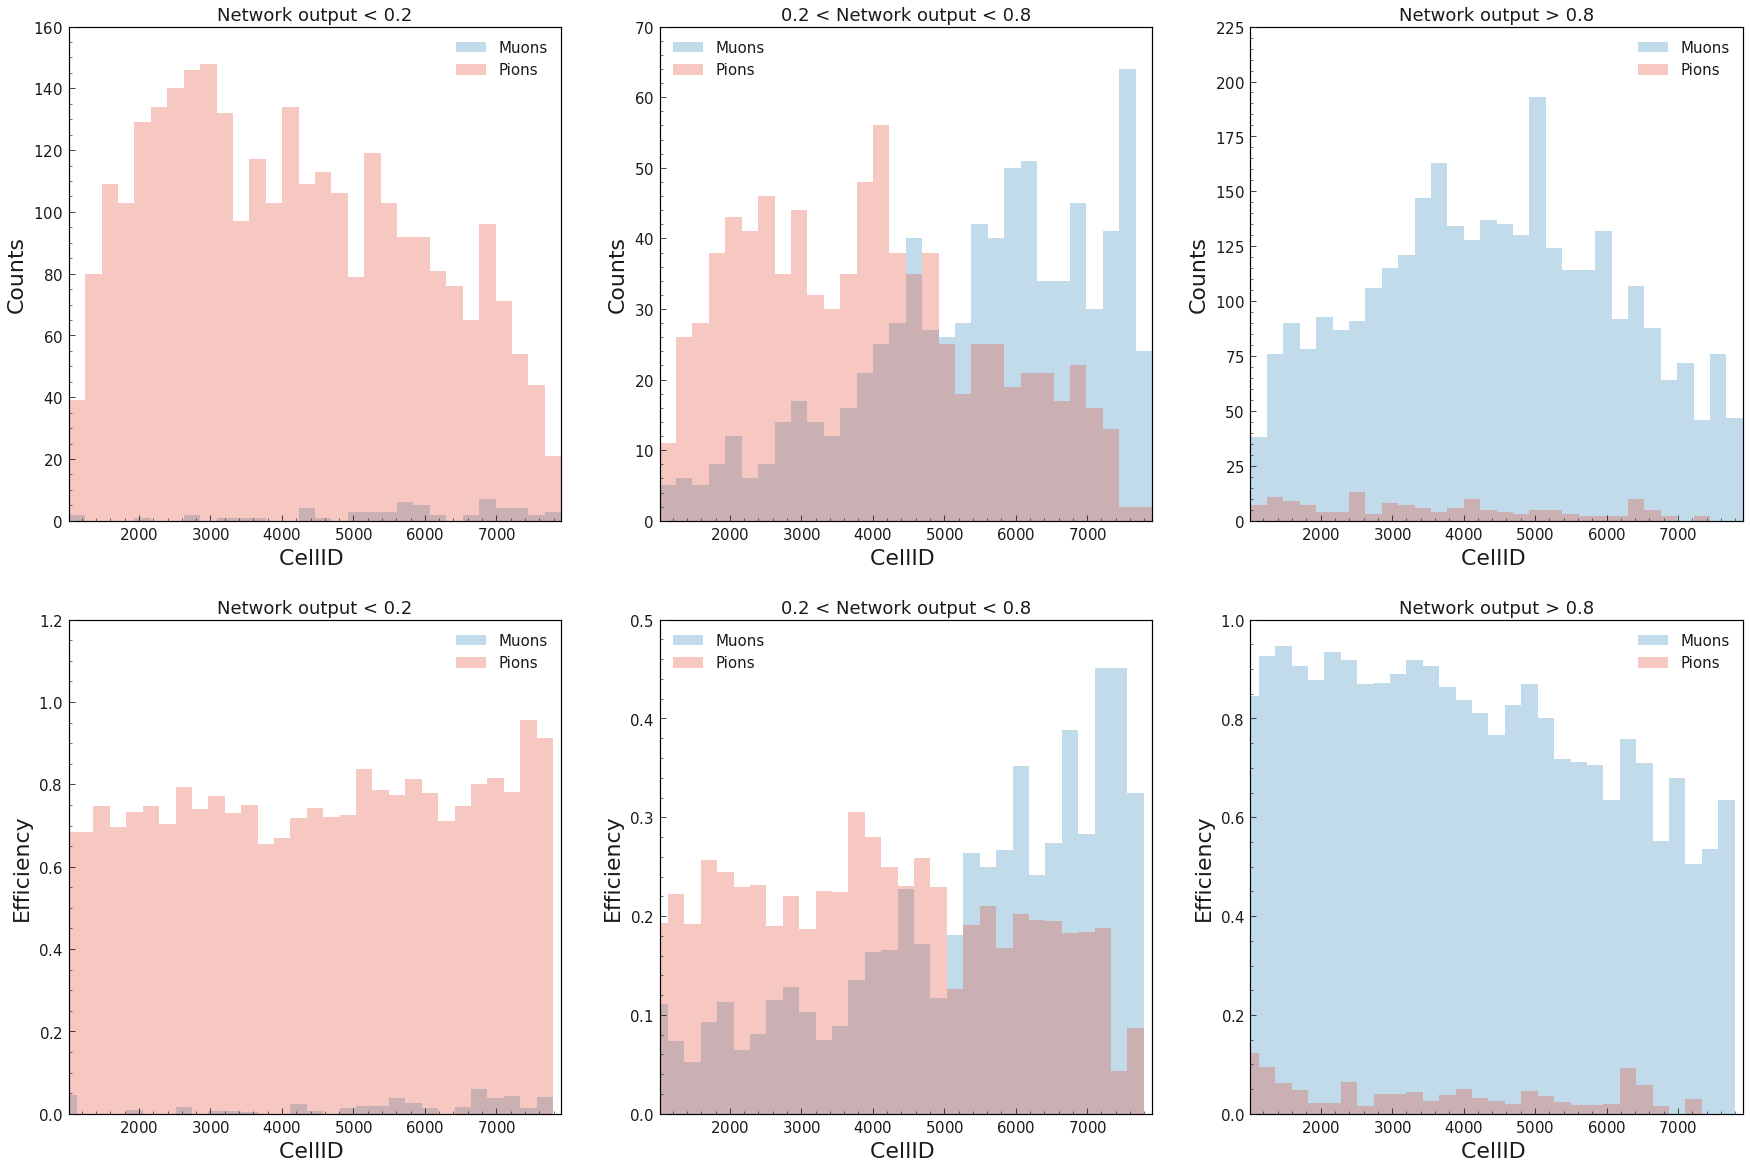

In [36]:
print_hist_efficiency("CellID", bins=30)

### Crystal energy

/cvmfs/belle.cern.ch/el7/externals/v01-09-01/Linux_x86_64/common/lib/python3.6/site-packages/ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in true_divide
/cvmfs/belle.cern.ch/el7/externals/v01-09-01/Linux_x86_64/common/lib/python3.6/site-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in true_divide
/cvmfs/belle.cern.ch/el7/externals/v01-09-01/Linux_x86_64/common/lib/python3.6/site-packages/ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in true_divide
/cvmfs/belle.cern.ch/el7/externals/v01-09-01/Linux_x86_64/common/lib/python3.6/site-packages/ipykernel_launcher.py:62: RuntimeWarning: invalid value encountered in true_divide
/cvmfs/belle.cern.ch/el7/externals/v01-09-01/Linux_x86_64/common/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: invalid value encountered in true_divide
/cvmfs/belle.cern.ch/el7/externals/v01-09-01/Linux_x86_64/common/lib/python3.6/site-packages/ipykernel_launcher.py:72: R

Count minimum in region 1 = 1.0 (muons), 31.0 (pions)
Count minimum in region 2 = 2.0 (muons), 3.0 (pions)
Count minimum in region 3 = 30.0 (muons), 1.0 (pions)


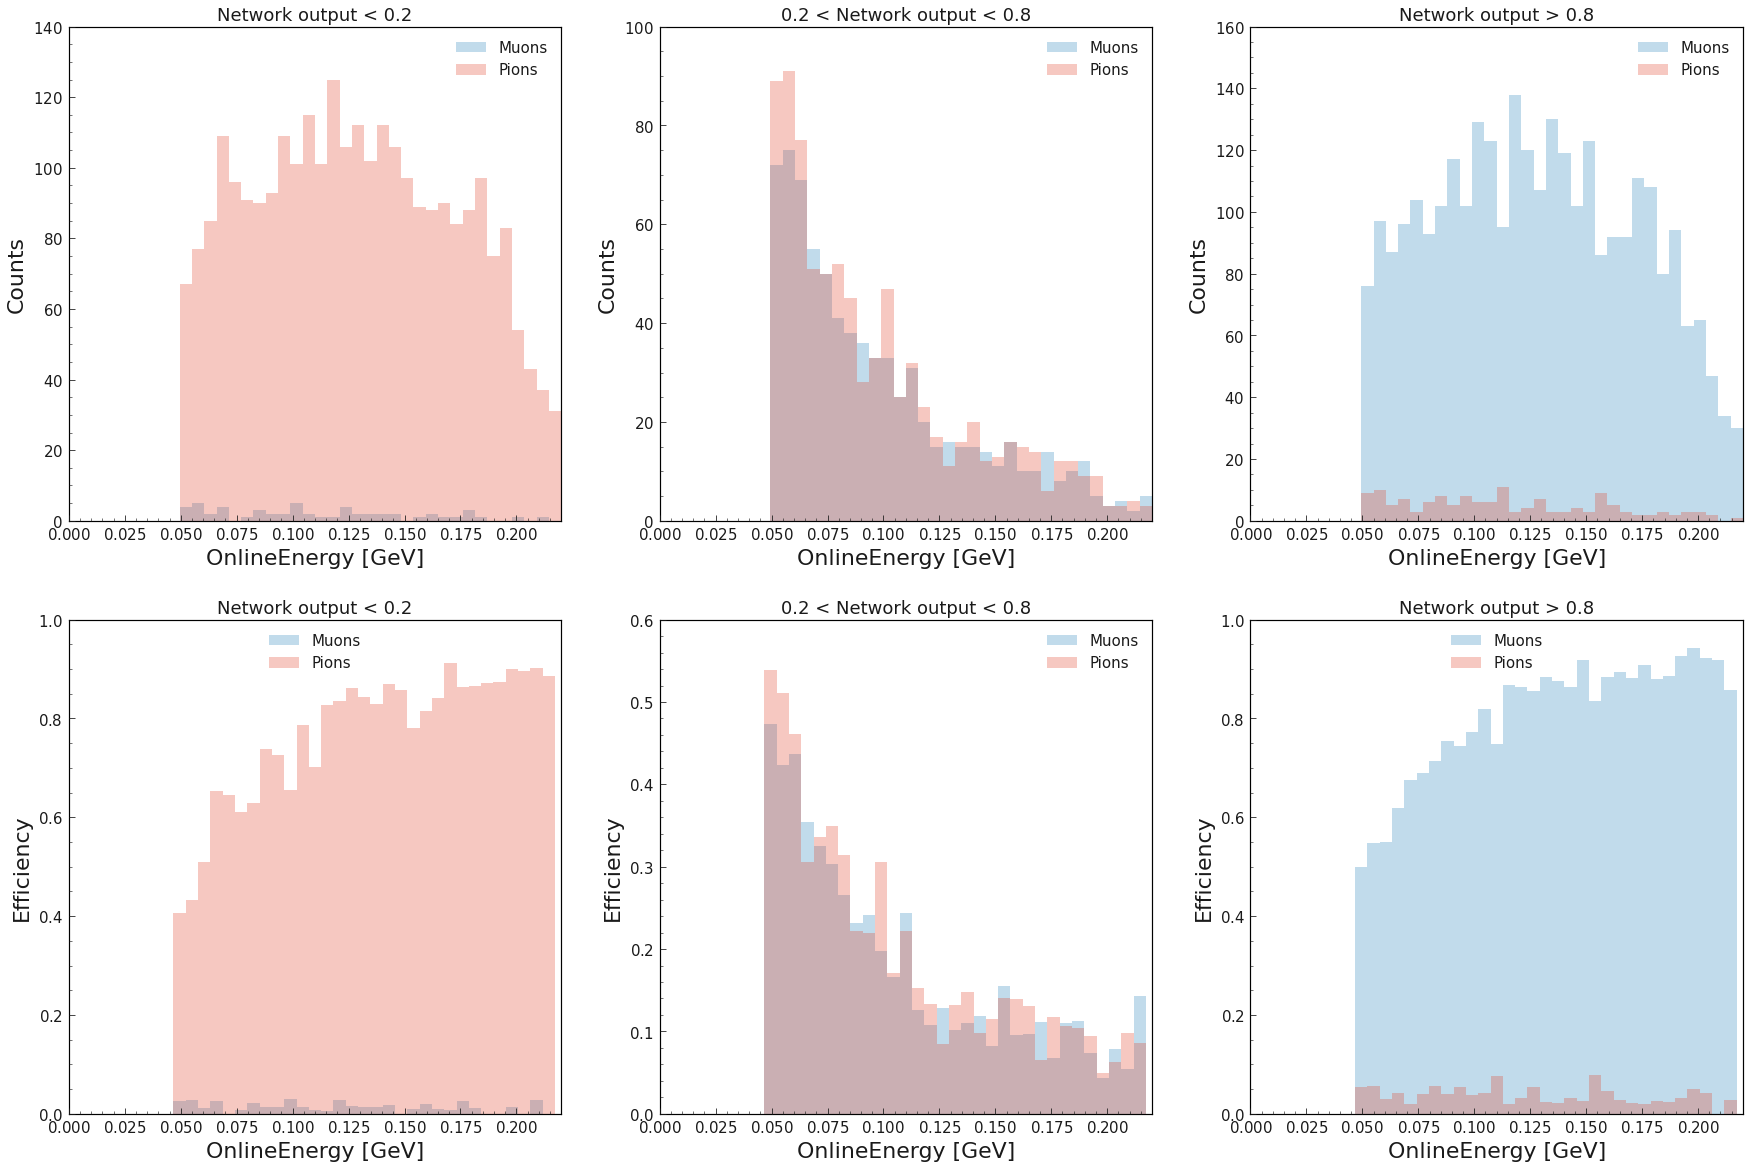

In [37]:
print_hist_efficiency("OnlineEnergy", range=(0,.22), unit="GeV", bins=40)

### Hadron Intensity

/cvmfs/belle.cern.ch/el7/externals/v01-09-01/Linux_x86_64/common/lib/python3.6/site-packages/ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in true_divide
/cvmfs/belle.cern.ch/el7/externals/v01-09-01/Linux_x86_64/common/lib/python3.6/site-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in true_divide
/cvmfs/belle.cern.ch/el7/externals/v01-09-01/Linux_x86_64/common/lib/python3.6/site-packages/ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in true_divide
/cvmfs/belle.cern.ch/el7/externals/v01-09-01/Linux_x86_64/common/lib/python3.6/site-packages/ipykernel_launcher.py:62: RuntimeWarning: invalid value encountered in true_divide
/cvmfs/belle.cern.ch/el7/externals/v01-09-01/Linux_x86_64/common/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: invalid value encountered in true_divide
/cvmfs/belle.cern.ch/el7/externals/v01-09-01/Linux_x86_64/common/lib/python3.6/site-packages/ipykernel_launcher.py:72: R

Count minimum in region 1 = 1.0 (muons), 1.0 (pions)
Count minimum in region 2 = 1.0 (muons), 1.0 (pions)
Count minimum in region 3 = 1.0 (muons), 1.0 (pions)


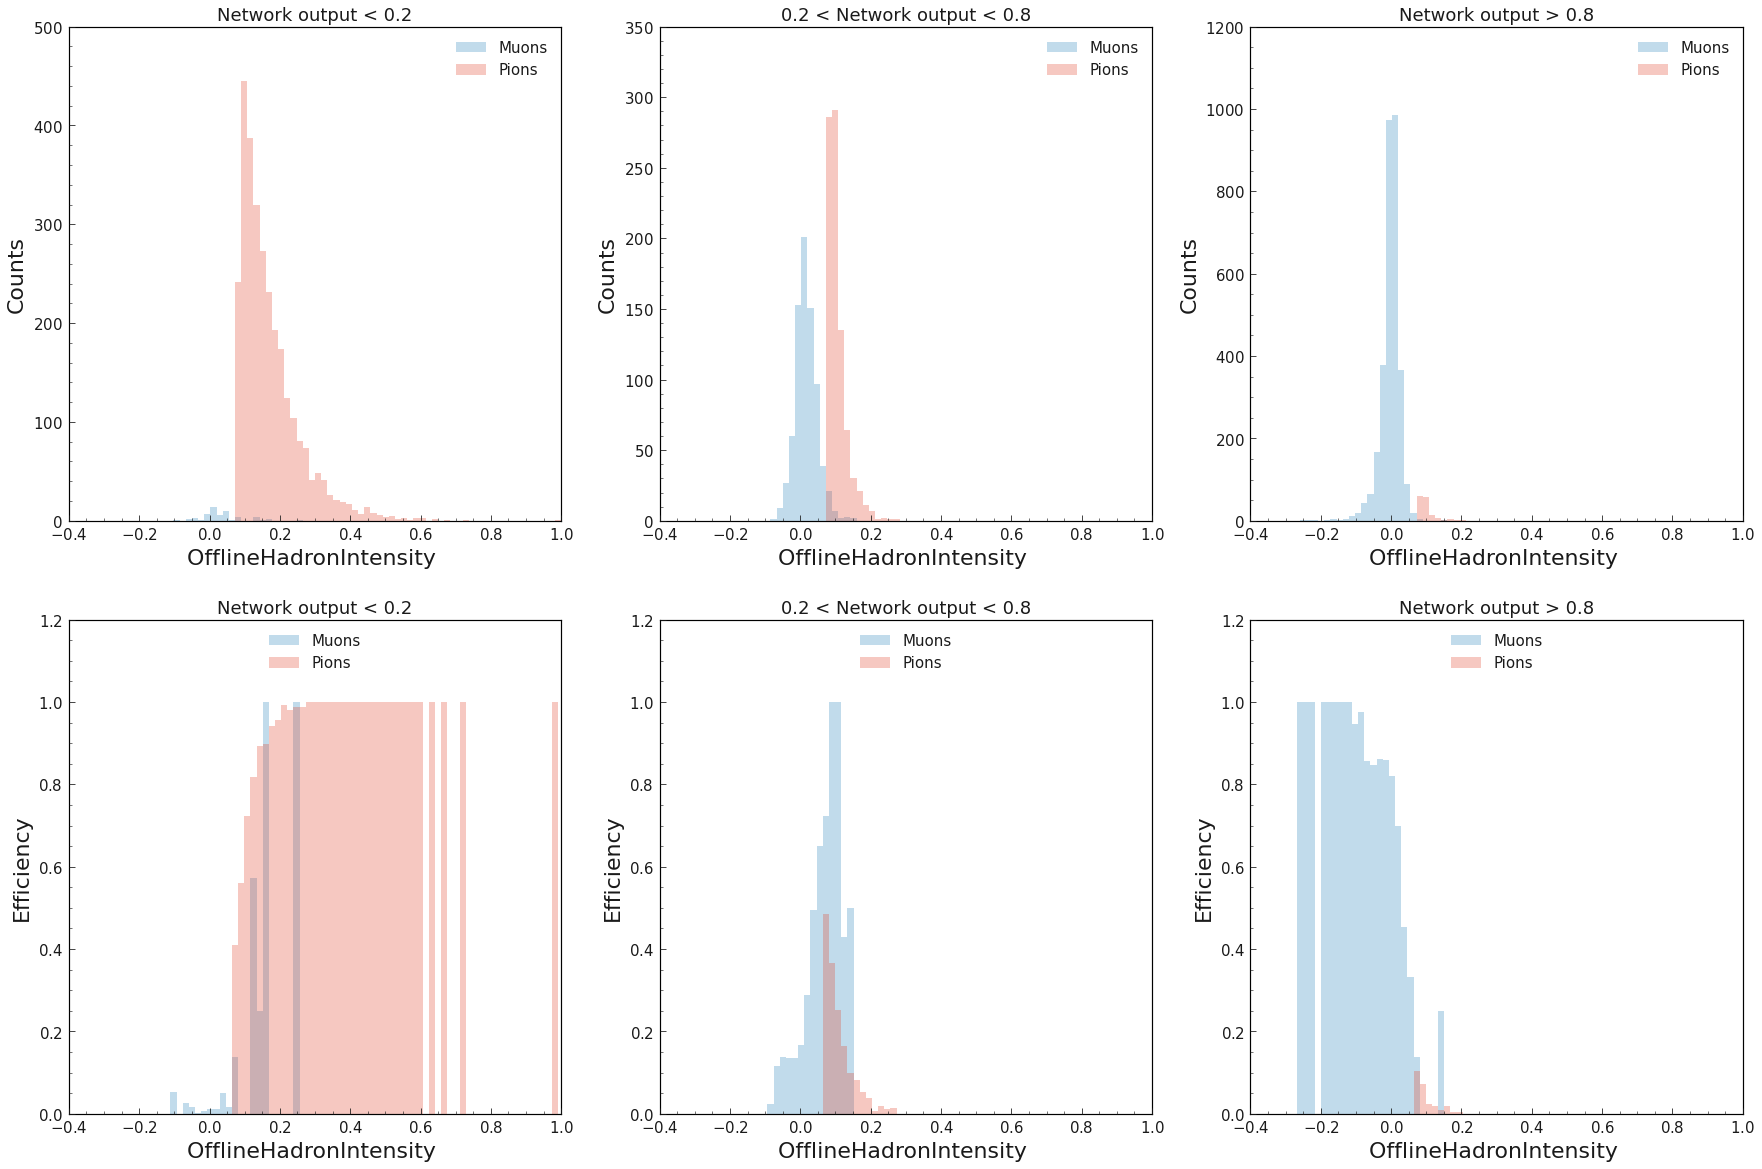

In [38]:
print_hist_efficiency("OfflineHadronIntensity", range=(-.4, 1), bins=80)

### Online Energy + OfflineHadronIntensity

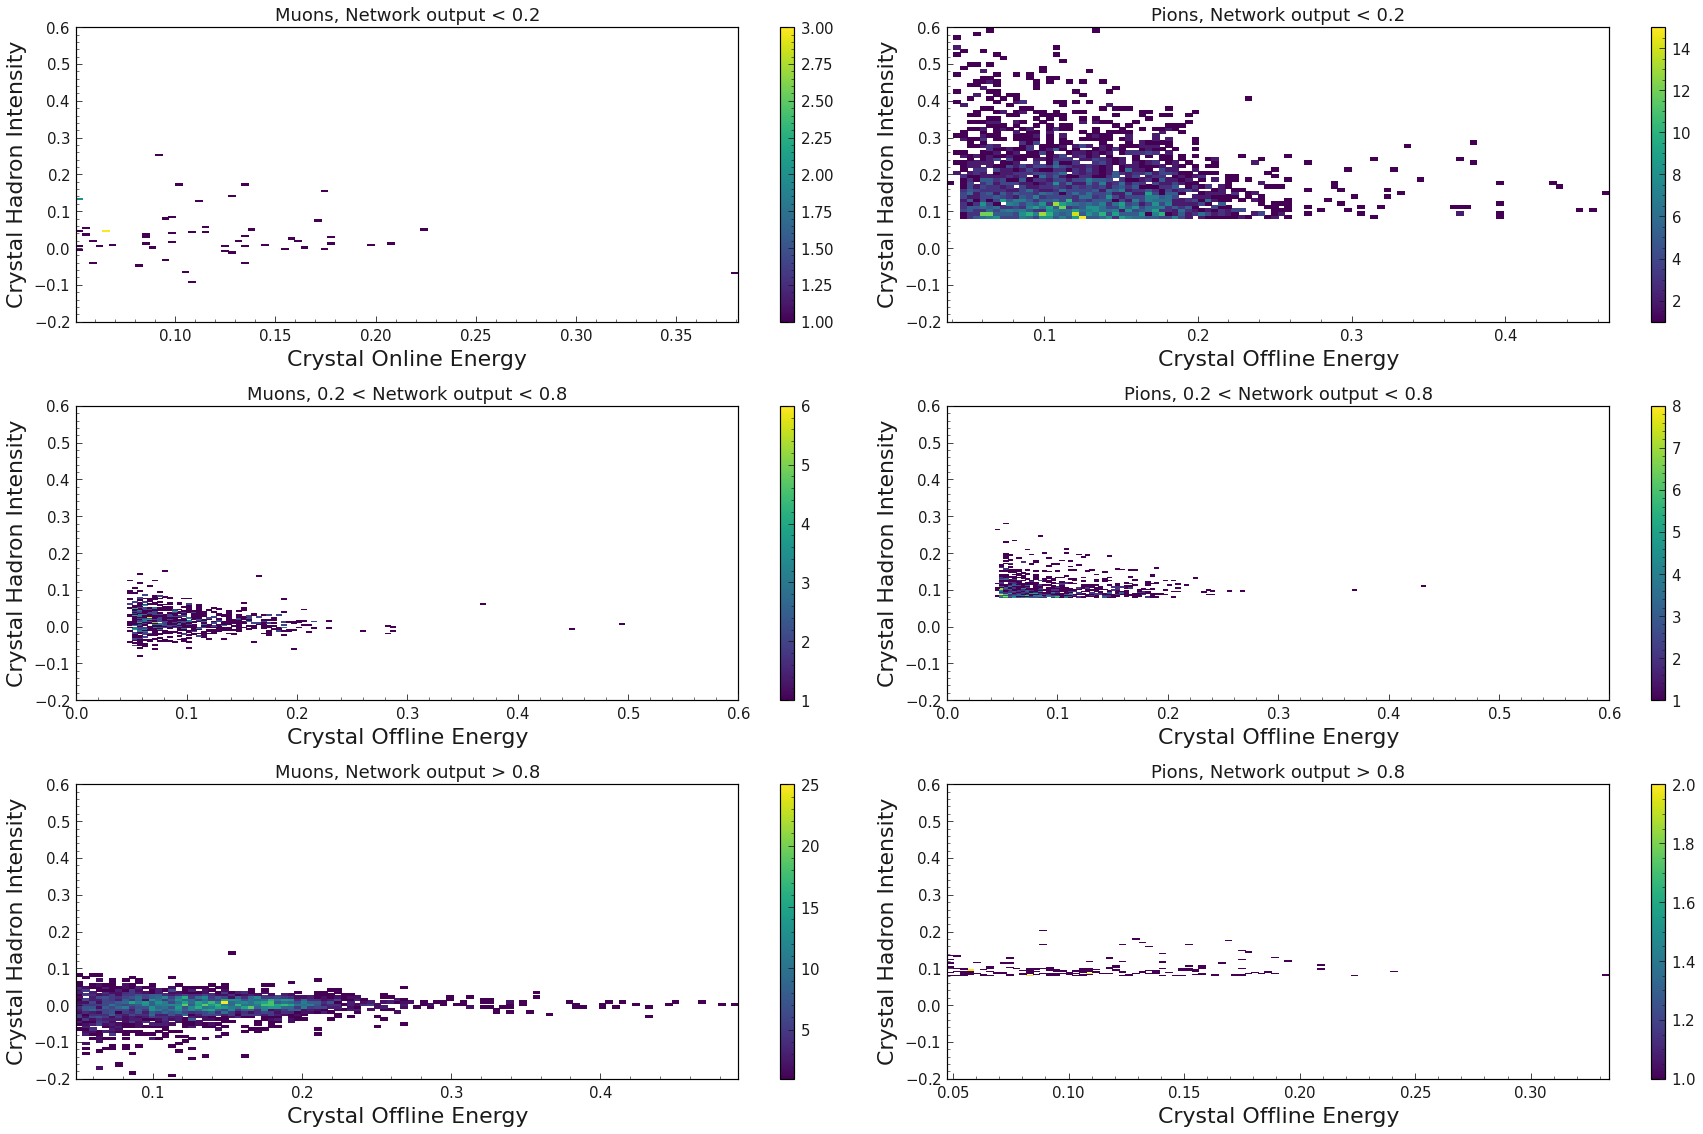

In [39]:
plt.figure(figsize=(25,16))

nbins = 100

plt.subplot(3,2,1)
_ = plt.hist2d(muons_region1["OfflineEnergy"], muons_region1["OfflineHadronIntensity"], bins=nbins, cmin=1, label="Muons")

plt.title("Muons, Network output < {}".format(liminf))
plt.xlabel("Crystal Online Energy")
plt.ylabel("Crystal Hadron Intensity")
plt.ylim((-0.2, 0.6))

plt.colorbar()


plt.subplot(3,2,2)
_ = plt.hist2d(pions_region1["OfflineEnergy"].to_numpy(), pions_region1["OfflineHadronIntensity"].to_numpy(), bins=nbins, cmin=1, label="Pions")

plt.title("Pions, Network output < {}".format(liminf))
plt.xlabel("Crystal Offline Energy")
plt.ylabel("Crystal Hadron Intensity")
plt.ylim((-0.2, 0.6))

plt.colorbar()


plt.subplot(3,2,3)
_ = plt.hist2d(muons_region2["OfflineEnergy"], muons_region2["OfflineHadronIntensity"], bins=nbins, cmin=1, label="Muons")

plt.title("Muons, {} < Network output < {}".format(liminf, limsup))
plt.xlabel("Crystal Offline Energy")
plt.ylabel("Crystal Hadron Intensity")
plt.xlim((0,.6))
plt.ylim((-0.2, 0.6))

plt.colorbar()


plt.subplot(3,2,4)
_ = plt.hist2d(pions_region2["OfflineEnergy"], pions_region2["OfflineHadronIntensity"], bins=nbins, cmin=1, label="Pions")

plt.title("Pions, {} < Network output < {}".format(liminf, limsup))
plt.xlabel("Crystal Offline Energy")
plt.ylabel("Crystal Hadron Intensity")
plt.xlim((0,.6))
plt.ylim((-0.2, 0.6))

plt.colorbar()


plt.subplot(3,2,5)
_ = plt.hist2d(muons_region3["OfflineEnergy"], muons_region3["OfflineHadronIntensity"], bins=nbins, cmin=1, label="Muons")

plt.title("Muons, Network output > {}".format(limsup))
plt.xlabel("Crystal Offline Energy")
plt.ylabel("Crystal Hadron Intensity")
plt.ylim((-0.2, 0.6))

plt.colorbar()


plt.subplot(3,2,6)
_ = plt.hist2d(pions_region3["OfflineEnergy"].to_numpy(), pions_region3["OfflineHadronIntensity"].to_numpy(), bins=nbins, cmin=1, label="Pions")

plt.title("Pions, Network output > {}".format(limsup))
plt.xlabel("Crystal Offline Energy")
plt.ylabel("Crystal Hadron Intensity")
plt.ylim((-0.2, 0.6))

plt.colorbar()

plt.tight_layout()

### Hadron intensity VS Network output

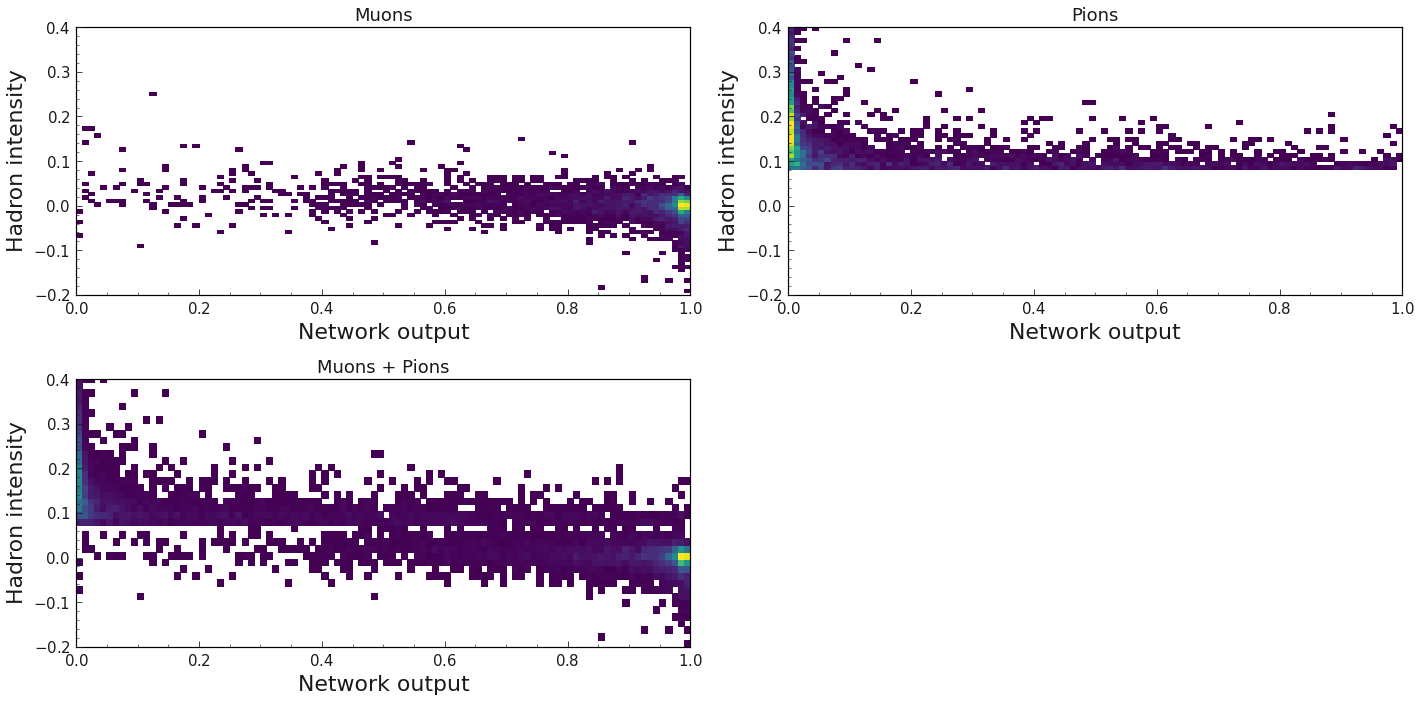

In [57]:
plt.figure(figsize=(20,10))

nbins = 100

plt.subplot(2,2,1)
_ = plt.hist2d(preds_muons.flatten(), test_df[test_y == 1]["OfflineHadronIntensity"], bins=(nbins, nbins), cmin=1, label="Muons")

plt.xlim((0, 1))
plt.ylim((-.2, .4))

plt.title("Muons")
plt.xlabel("Network output")
plt.ylabel("Hadron intensity")

plt.subplot(2,2,2)
_ = plt.hist2d(preds_pions.flatten(), test_df[test_y == 0]["OfflineHadronIntensity"], bins=(nbins, nbins), cmin=1, label="Muons")

plt.title("Pions")

plt.xlim((0, 1))
plt.ylim((-.2, .4))

plt.xlabel("Network output")
plt.ylabel("Hadron intensity")

plt.subplot(2,2,3)
_ = plt.hist2d(np.hstack([preds_muons.flatten(),preds_pions.flatten()]), pd.concat([test_df[test_y == 1]["OfflineHadronIntensity"],test_df[test_y == 0]["OfflineHadronIntensity"]]), bins=(nbins, nbins), cmin=1, label="Muons")

plt.title("Muons + Pions")

plt.xlim((0, 1))
plt.ylim((-.2, .4))

plt.xlabel("Network output")
plt.ylabel("Hadron intensity")


plt.tight_layout()

<br>

# Network inference

In [8]:
filepath = "./CNN_PulseShapeCut_var1_23-08-2021-12:46:49"

model = keras.models.load_model(filepath)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



## Dataset 1: Total dataset

In [4]:
muon_dataset_tot = pd.read_csv("../DataSelection-Muons.csv")
muon_dataset_tot.replace("ee_mumug", 1, inplace = True)

pion_dataset_tot = pd.read_csv("../DataSelection-Pions.csv")
pion_dataset_tot.replace("KS0_pipi", 0, inplace = True)

In [5]:
muon_dataset_tot = muon_dataset_tot[np.logical_and(muon_dataset_tot["Momentum"] > 1, muon_dataset_tot["Momentum"] < 2.8)]
pion_dataset_tot = pion_dataset_tot[np.logical_and(pion_dataset_tot["Momentum"] > 1, pion_dataset_tot["Momentum"] < 2.8)]

Text(0, 0.5, 'Hadron intensity')

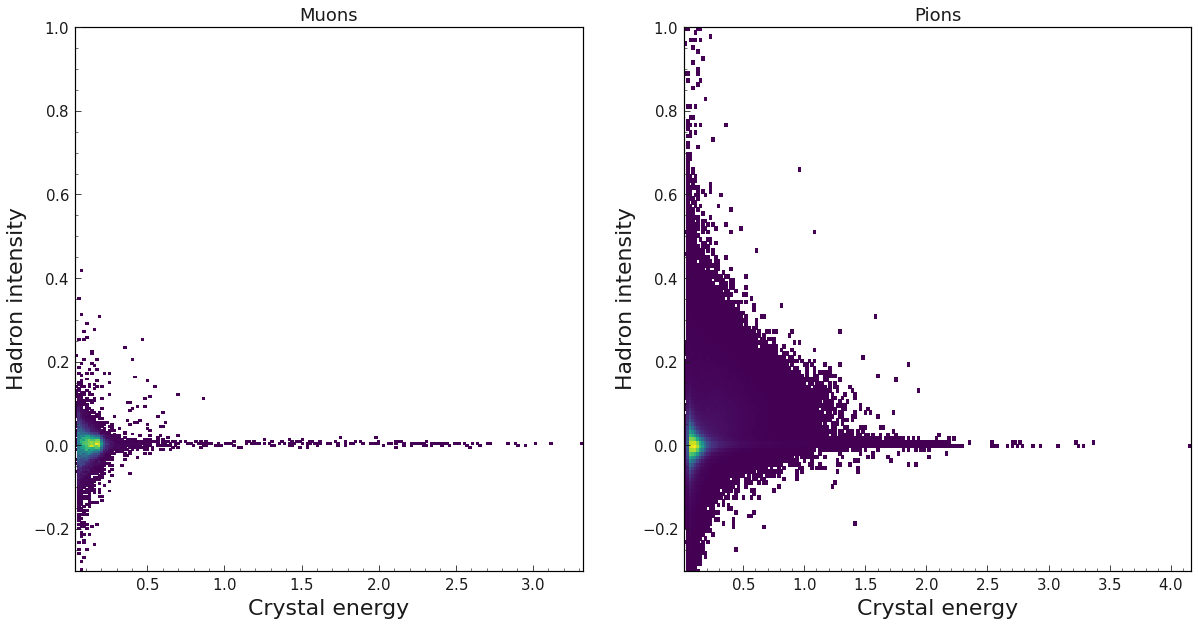

In [7]:
plt.figure(figsize=(20,10))

plt.subplot(1,2,1)
plt.hist2d(muon_dataset_tot[muon_dataset_tot["OfflineEnergy"] > 0]["OfflineEnergy"], muon_dataset_tot[muon_dataset_tot["OfflineEnergy"] > 0]["OfflineHadronIntensity"], cmin=1, bins=200)

plt.ylim((-.3, 1))
plt.title("Muons")

plt.xlabel("Crystal energy")
plt.ylabel("Hadron intensity")


plt.subplot(1,2,2)
plt.hist2d(pion_dataset_tot[pion_dataset_tot["OfflineEnergy"] > 0]["OfflineEnergy"], pion_dataset_tot[pion_dataset_tot["OfflineEnergy"] > 0]["OfflineHadronIntensity"], cmin=1, bins=200)

plt.ylim((-.3, 1))
plt.title("Pions")
plt.xlabel("Crystal energy")
plt.ylabel("Hadron intensity")


In [9]:
muon_x = np.stack([muon_dataset_tot[col].div(norm).values for col in waveform_columns], 1)
pion_x = np.stack([pion_dataset_tot.iloc[:muon_dataset_tot.shape[0]][col].div(norm).values for col in waveform_columns], 1)

muon_x = muon_x.reshape(muon_x.shape[0], 31, 1)
pion_x = pion_x.reshape(pion_x.shape[0], 31, 1)

muon_y = np.stack([muon_dataset_tot[col].values for col in output_columns], 1)
pion_y = np.stack([pion_dataset_tot.iloc[:muon_dataset_tot.shape[0]][col].values for col in output_columns], 1)

dataset_tot_x = np.vstack((muon_x, pion_x))
dataset_tot_y = np.vstack((muon_y, pion_y))

In [10]:
preds_muons_tot = model.predict(muon_x)
preds_pions_tot = model.predict(pion_x)

print("Muons: ", preds_muons_tot)
print("Pions: ", preds_pions_tot)

Muons:  [[8.6065912e-01]
 [5.6511843e-01]
 [9.9309957e-01]
 ...
 [8.1600547e-03]
 [8.0774602e-04]
 [0.0000000e+00]]
Pions:  [[0.02729288]
 [0.09900913]
 [0.9876282 ]
 ...
 [0.02485189]
 [0.942656  ]
 [0.9908057 ]]


AUC =  0.5415472215969208


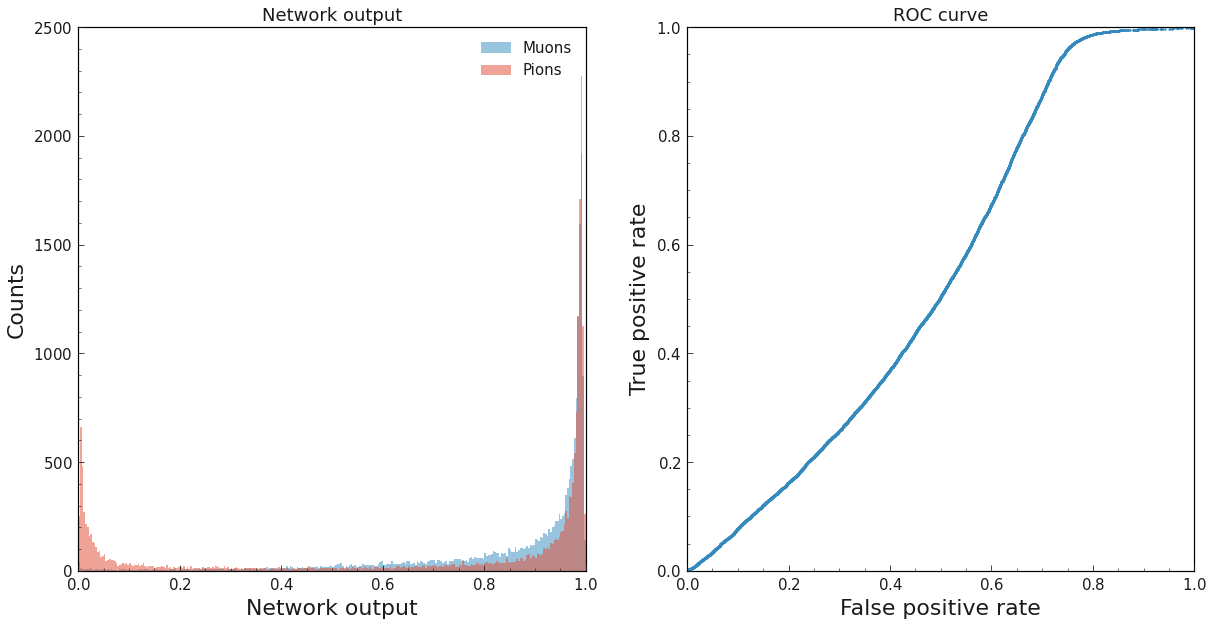

In [11]:
### Network output

plt.figure(figsize=(20,10))

# Network output
plt.subplot(1,2,1)
plt.hist(preds_muons_tot, bins = 300, alpha = 0.5, label = "Muons")
plt.hist(preds_pions_tot, bins = 300, alpha = 0.5, label = "Pions")

plt.xlim((0,1))

plt.title("Network output")
plt.xlabel("Network output")
plt.ylabel("Counts")

plt.legend()


# ROC curve

# DENSE NETWORK
plt.subplot(1,2,2)
roc_out = roc_curve(dataset_tot_y, model.predict(dataset_tot_x))
print("AUC = ", roc_auc_score(dataset_tot_y, model.predict(dataset_tot_x)))
fpr, tpr = roc_out[0], roc_out[1]
plt.scatter(fpr, tpr, s=1, alpha=.9)

plt.xlim((0,1))
plt.ylim((0,1))

plt.title("ROC curve")
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")

plt.savefig("./figures/CNN_whole_output_ROC.pdf")

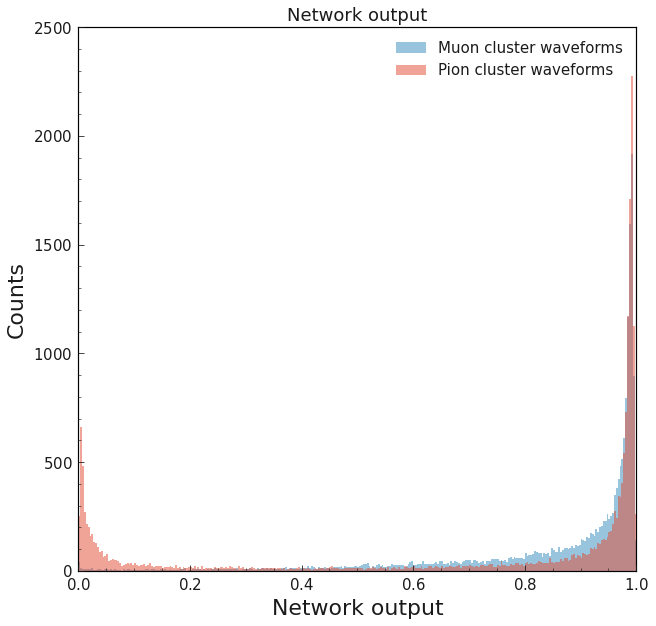

In [12]:
plt.figure(figsize=(10,10))

plt.hist(preds_muons_tot, bins = 300, alpha = 0.5, label = "Muon cluster waveforms")
plt.hist(preds_pions_tot, bins = 300, alpha = 0.5, label = "Pion cluster waveforms")

plt.xlim((0,1))

plt.title("Network output")
plt.xlabel("Network output")
plt.ylabel("Counts")

plt.legend()

plt.savefig("./figures/CNN_whole_output.pdf")

AUC =  0.5415472215969208


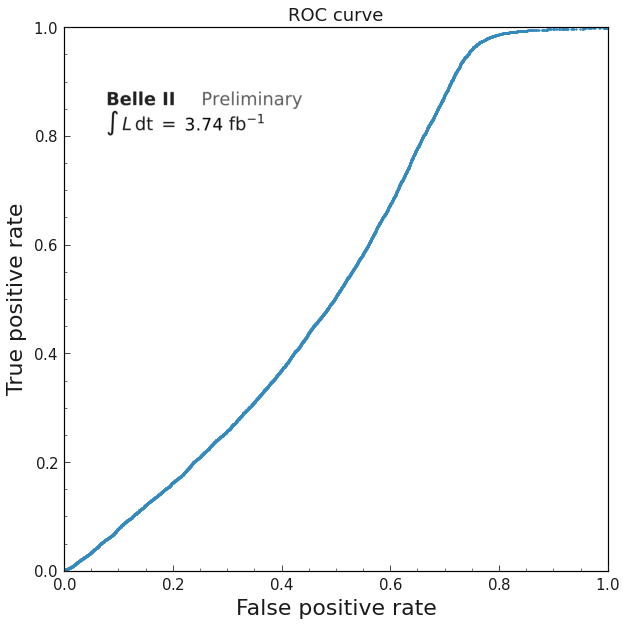

In [63]:
plt.figure(figsize=(10,10))


roc_out = roc_curve(dataset_tot_y, model.predict(dataset_tot_x))
print("AUC = ", roc_auc_score(dataset_tot_y, model.predict(dataset_tot_x)))
fpr, tpr = roc_out[0], roc_out[1]
plt.scatter(fpr, tpr, s=1, alpha=.9)

plt.xlim((0,1))
plt.ylim((0,1))

plt.title("ROC curve")
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")

image = plt.imread("./figures/belleii_sign.png")
plt.imshow(image, origin="upper", extent=[0.05,0.5-0.05,0.9-0.4*192/695,0.9])

plt.savefig("./figures/CNN_whole_ROC.pdf")

## Dataset 2: ionizing particles

In [11]:
# dataset_ion = pd.concat([muon_dataset_tot, pion_dataset_tot], ignore_index=True)
# dataset_ion = dataset_ion.sample(frac = 1)

In [13]:
# muon_dataset_ion = muon_dataset_tot[np.logical_and.reduce((muon_dataset_tot["ClusterE"] < .3, muon_dataset_tot["ClusterE"] > .15))]
pion_dataset_ion = pion_dataset_tot[np.logical_and.reduce((pion_dataset_tot["ClusterE"] > .15, pion_dataset_tot["ClusterE"] < .3))]

In [14]:
muon_hist_ion = plt.hist(muon_dataset_tot["Momentum"], label = "Muons", bins = 100, alpha = 0.5)
plt.clf()

pion_hist_ion = plt.hist(pion_dataset_ion["Momentum"], label = "Pions", bins = 100, alpha = 0.5)
plt.clf()

hist_ratio_ion = muon_hist_ion[0]/pion_hist_ion[0]

<Figure size 576x396 with 0 Axes>

In [15]:
pion_dataset_ion["r"] = np.random.uniform(0, 1, pion_dataset_ion.shape[0])
pion_dataset_ion = pion_dataset_ion.iloc[np.where(pion_dataset_ion["r"] < hist_ratio_ion[np.digitize(pion_dataset_ion["Momentum"], pion_hist_ion[1][1:], right=True)])]

pion_dataset_ion.drop("r", axis=1, inplace=True)

/cvmfs/belle.cern.ch/el7/externals/v01-09-01/Linux_x86_64/common/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [16]:
muon_x = np.stack([muon_dataset_tot[col].div(norm).values for col in waveform_columns], 1)
pion_x = np.stack([pion_dataset_ion[col].div(norm).values[:muon_dataset_tot.shape[0]] for col in waveform_columns], 1)

muon_x = muon_x.reshape(muon_x.shape[0], 31, 1)
pion_x = pion_x.reshape(pion_x.shape[0], 31, 1)


muon_y = np.stack([muon_dataset_tot[col].values for col in output_columns], 1)
pion_y = np.stack([pion_dataset_ion[col].values[:muon_dataset_tot.shape[0]] for col in output_columns], 1)

dataset_ion_x = np.vstack((muon_x, pion_x))
dataset_ion_y = np.vstack((muon_y, pion_y))

In [17]:
preds_muons_ion = model.predict(muon_x)
preds_pions_ion = model.predict(pion_x)

print("Muons: ", preds_muons_ion)
print("Pions: ", preds_pions_ion)

Muons:  [[8.6065912e-01]
 [5.6511843e-01]
 [9.9309957e-01]
 ...
 [8.1600547e-03]
 [8.0774602e-04]
 [0.0000000e+00]]
Pions:  [[0.9946835 ]
 [0.97050947]
 [0.99099326]
 ...
 [0.92577785]
 [0.78002965]
 [0.        ]]


In [ ]:
### Network output

plt.figure(figsize=(20,10))

# Network output
plt.subplot(1,2,1)
plt.hist(preds_muons_ion, bins = 300, alpha = 0.5, label = "Muons")
plt.hist(preds_pions_ion, bins = 300, alpha = 0.5, label = "Pions")

plt.xlim((0,1))

plt.title("Network output")
plt.xlabel("Network output")
plt.ylabel("Counts")

plt.legend()


# ROC curve

# DENSE NETWORK
plt.subplot(1,2,2)
roc_out = roc_curve(dataset_ion_y, model.predict(dataset_ion_x))
print("AUC = ", roc_auc_score(dataset_ion_y, model.predict(dataset_ion_x)))
fpr, tpr = roc_out[0], roc_out[1]
plt.scatter(fpr, tpr, s=1, alpha=.9)

plt.xlim((0,1))
plt.ylim((0,1))

plt.title("ROC curve")
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")

plt.savefig("./figures/CNN_ionizing_output_ROC.pdf")

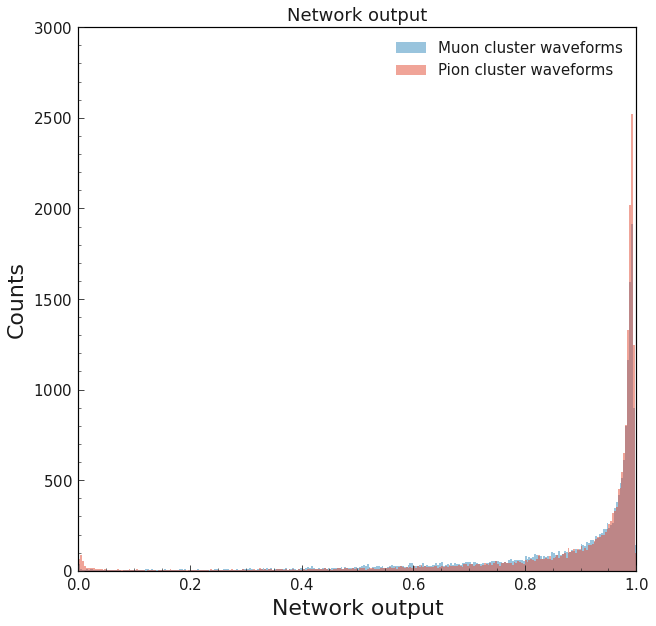

In [17]:
plt.figure(figsize=(10,10))

# Network output
plt.hist(preds_muons_ion, bins = 300, alpha = 0.5, label = "Muon cluster waveforms")
plt.hist(preds_pions_ion, bins = 300, alpha = 0.5, label = "Pion cluster waveforms")

plt.xlim((0,1))

plt.title("Network output")
plt.xlabel("Network output")
plt.ylabel("Counts")

plt.legend()

plt.savefig("./figures/CNN_ionizing_output.pdf")

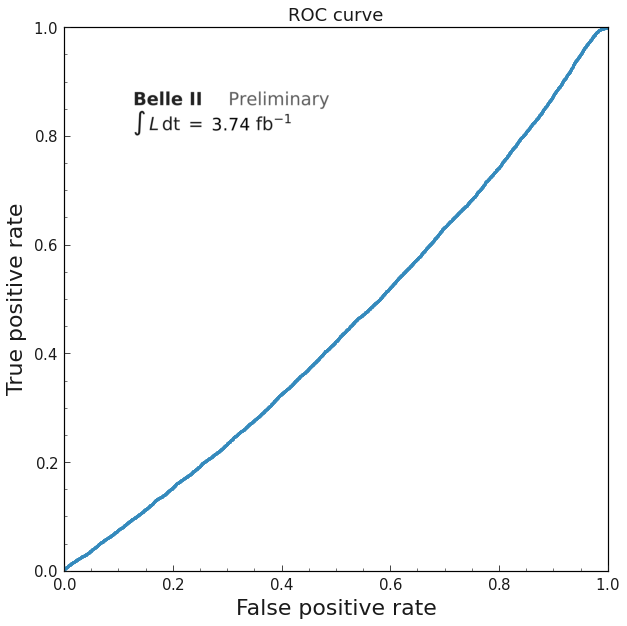

In [60]:
plt.figure(figsize=(10,10))

#roc_out = roc_curve(dataset_ion_y, model.predict(dataset_ion_x))
#print("AUC = ", roc_auc_score(dataset_ion_y, model.predict(dataset_ion_x)))
#fpr, tpr = roc_out[0], roc_out[1]
plt.scatter(fpr, tpr, s=1, alpha=.9)

plt.xlim((0,1))
plt.ylim((0,1))

plt.title("ROC curve")
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")

image = plt.imread("./figures/belleii_sign.png")
plt.imshow(image, origin="upper", extent=[0.1,0.5,0.9-0.4*192/695,0.9])

plt.savefig("./figures/CNN_ionizing_ROC.pdf")

In [25]:
muons_g95 = muon_dataset_tot[preds_muons_ion > 0.95]
pions_g95 = pion_dataset_ion[preds_pions_ion > 0.95]

muons_l95 = muon_dataset_tot[preds_muons_ion < 0.95]
pions_l95 = pion_dataset_ion[preds_pions_ion < 0.95]

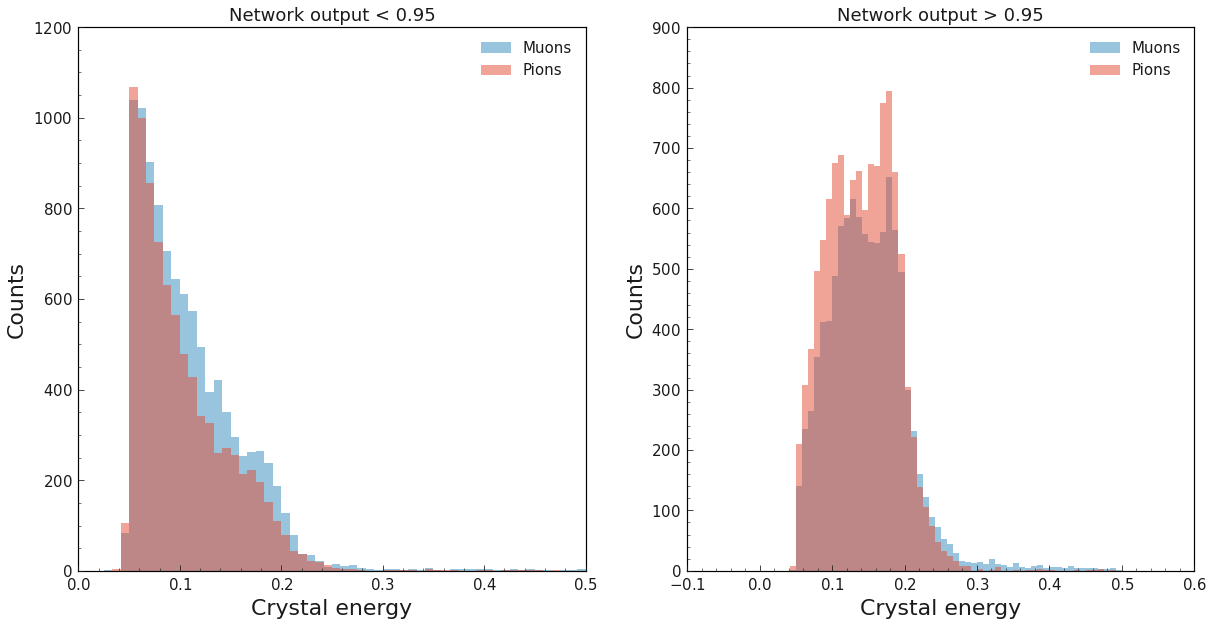

In [19]:
plt.figure(figsize=(20,10))

oerange = (0, .5)

plt.subplot(1,2,1)
plt.hist(muons_l95[muons_l95["OfflineEnergy"] >= 0]["OfflineEnergy"], alpha=0.5, bins=60, range=oerange, label="Muons")
plt.hist(pions_l95[pions_l95["OfflineEnergy"] >= 0]["OfflineEnergy"], alpha=0.5, bins=60, range=oerange, label="Pions")

plt.title("Network output < 0.95")
plt.xlabel("Crystal energy")
plt.ylabel("Counts")
plt.xlim(oerange)

plt.xlim(oerange)
plt.legend()

# -------------------------------------------------------------------------------------------

plt.subplot(1,2,2)

plt.hist(muons_g95[muons_g95["OfflineEnergy"] >= 0]["OfflineEnergy"], alpha=0.5, bins=60, range=oerange, label="Muons")
plt.hist(pions_g95[pions_g95["OfflineEnergy"] >= 0]["OfflineEnergy"], alpha=0.5, bins=60, range=oerange, label="Pions")

plt.title("Network output > 0.95")
plt.xlabel("Crystal energy")
plt.ylabel("Counts")

plt.legend()

## Dataset 3: showering particles

In [18]:
# muon_dataset_show = muon_dataset_tot[np.logical_or.reduce((muon_dataset_tot["ClusterE"] < .15, muon_dataset_tot["ClusterE"] > .3))]
pion_dataset_show = pion_dataset_tot[np.logical_or.reduce((pion_dataset_tot["ClusterE"] < .15, pion_dataset_tot["ClusterE"] > .3))]

pion_dataset_show = pion_dataset_show.iloc[:muon_dataset_tot.shape[0]]

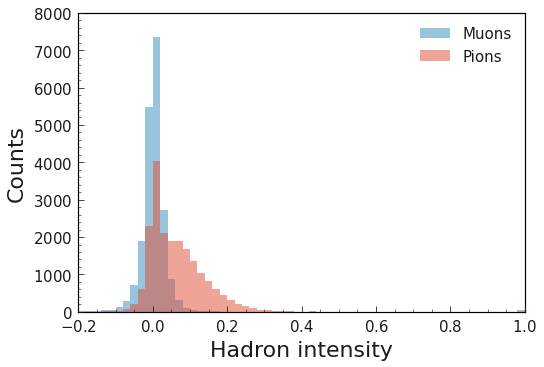

In [27]:
plt.hist(muon_dataset_tot["OfflineHadronIntensity"], alpha=0.5, bins=60, range=(-.2, 1), label="Muons")
plt.hist(pion_dataset_show["OfflineHadronIntensity"], alpha=0.5, bins=60, range=(-.2, 1), label="Pions")

plt.xlabel("Hadron intensity")
plt.ylabel("Counts")
plt.xlim((-.2, 1))

plt.legend()

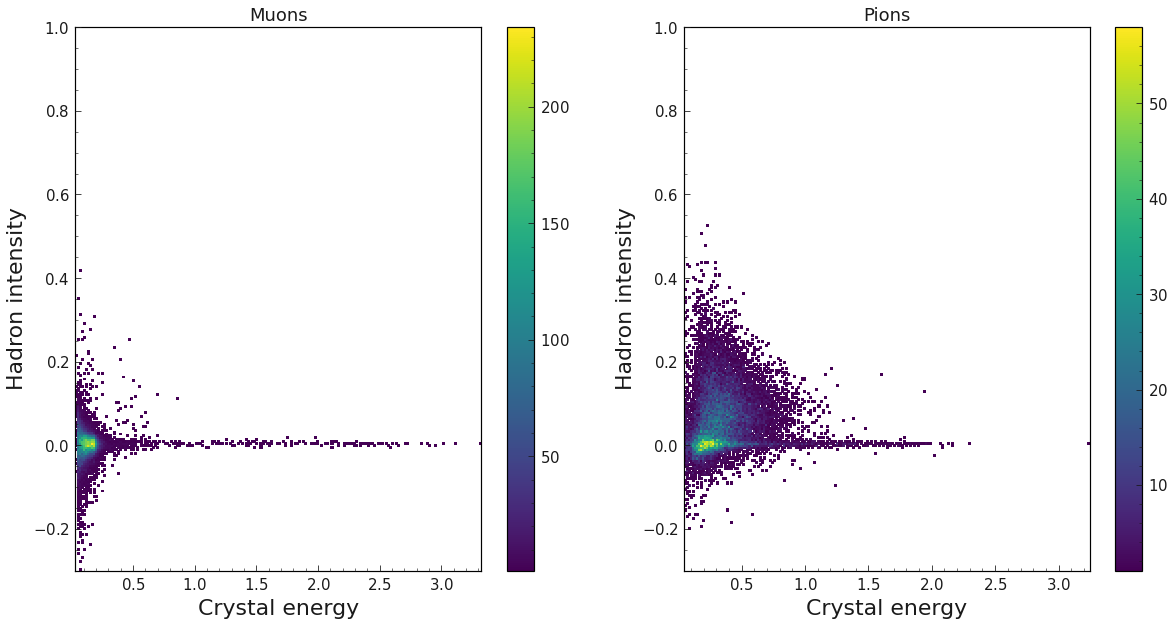

In [22]:
plt.figure(figsize=(20,10))

plt.subplot(1,2,1)
plt.hist2d(muon_dataset_tot[muon_dataset_tot["OfflineEnergy"] > 0]["OfflineEnergy"], muon_dataset_tot[muon_dataset_tot["OfflineEnergy"] > 0]["OfflineHadronIntensity"], cmin=1, bins=200)

plt.ylim((-.3, 1))
plt.title("Muons")

plt.xlabel("Crystal energy")
plt.ylabel("Hadron intensity")


plt.colorbar()

plt.subplot(1,2,2)
plt.hist2d(pion_dataset_show[pion_dataset_show["OfflineEnergy"] > 0]["OfflineEnergy"], pion_dataset_show[pion_dataset_show["OfflineEnergy"] > 0]["OfflineHadronIntensity"], cmin=1, bins=200)

plt.ylim((-.3, 1))
plt.title("Pions")
plt.xlabel("Crystal energy")
plt.ylabel("Hadron intensity")
plt.colorbar()

In [19]:
muon_x = np.stack([muon_dataset_tot[col].div(norm).values for col in waveform_columns], 1)
pion_x = np.stack([pion_dataset_show[col].div(norm).values for col in waveform_columns], 1)

muon_x = muon_x.reshape(muon_x.shape[0], 31, 1)
pion_x = pion_x.reshape(pion_x.shape[0], 31, 1)

muon_y = np.stack([muon_dataset_tot[col].values for col in output_columns], 1)
pion_y = np.stack([pion_dataset_show[col].values for col in output_columns], 1)

dataset_show_x = np.vstack((muon_x, pion_x))
dataset_show_y = np.vstack((muon_y, pion_y))

In [20]:
preds_muons_show = model.predict(muon_x)
preds_pions_show = model.predict(pion_x)

print("Muons: ", preds_muons_show)
print("Pions: ", preds_pions_show)

Muons:  [[8.6065912e-01]
 [5.6511843e-01]
 [9.9309957e-01]
 ...
 [8.1600547e-03]
 [8.0774602e-04]
 [0.0000000e+00]]
Pions:  [[0.02729288]
 [0.09900913]
 [0.9990265 ]
 ...
 [0.00722697]
 [0.95902926]
 [0.00830295]]


In [ ]:
### Network output

plt.figure(figsize=(20,10))

# Network output
plt.subplot(1,2,1)
plt.hist(preds_muons_show, bins = 300, alpha = 0.5, label = "Muons")
plt.hist(preds_pions_show, bins = 300, alpha = 0.5, label = "Pions")

plt.xlim((0,1))

plt.title("Network output")
plt.xlabel("Network output")
plt.ylabel("Counts")

plt.legend()


# ROC curve

# DENSE NETWORK
plt.subplot(1,2,2)
roc_out = roc_curve(dataset_show_y, model.predict(dataset_show_x))
print("AUC = ", roc_auc_score(dataset_show_y, model.predict(dataset_show_x)))
fpr, tpr = roc_out[0], roc_out[1]
plt.scatter(fpr, tpr, s=1, alpha=.9)

plt.xlim((0,1))
plt.ylim((0,1))

plt.title("ROC curve")
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")

plt.savefig("./figures/CNN_showering_output_ROC.pdf")

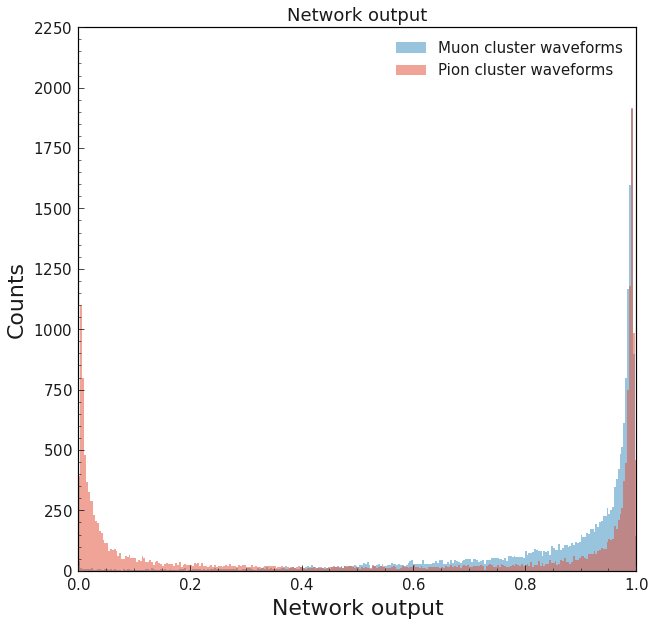

In [21]:
plt.figure(figsize=(10,10))

plt.hist(preds_muons_show, bins = 300, alpha = 0.5, label = "Muon cluster waveforms")
plt.hist(preds_pions_show, bins = 300, alpha = 0.5, label = "Pion cluster waveforms")

plt.xlim((0,1))

plt.title("Network output")
plt.xlabel("Network output")
plt.ylabel("Counts")

plt.legend()

plt.savefig("./figures/CNN_showering_output.pdf")

AUC =  0.6442620140909816


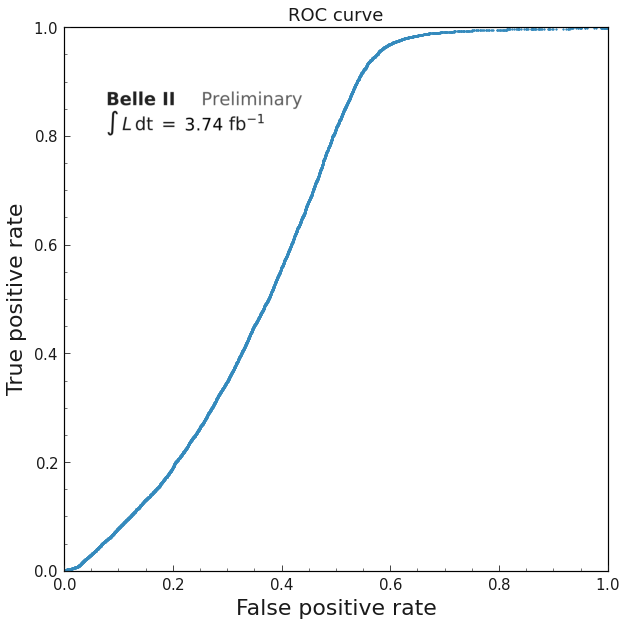

In [62]:
plt.figure(figsize=(10,10))

roc_out = roc_curve(dataset_show_y, model.predict(dataset_show_x))
print("AUC = ", roc_auc_score(dataset_show_y, model.predict(dataset_show_x)))
fpr, tpr = roc_out[0], roc_out[1]
plt.scatter(fpr, tpr, s=1, alpha=.9)

plt.xlim((0,1))
plt.ylim((0,1))

plt.title("ROC curve")
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")

image = plt.imread("./figures/belleii_sign.png")
plt.imshow(image, origin="upper", extent=[0.05,0.5-0.05,0.9-0.4*192/695,0.9])

plt.savefig("./figures/CNN_showering_ROC.pdf")

## Final ROC curve plots

AUC =  0.5415472215969208
AUC =  0.45305399945177044
AUC =  0.6442620140909816


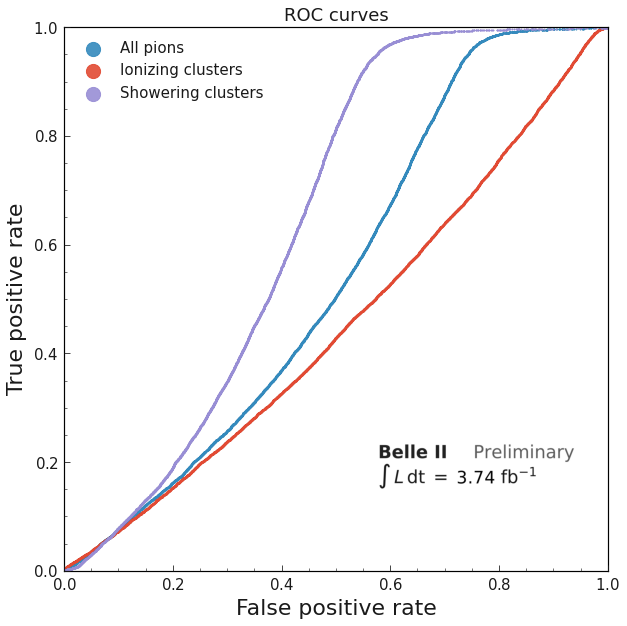

In [21]:
plt.figure(figsize=(10,10))
plt.rcParams["legend.markerscale"] = 20

roc_out = roc_curve(dataset_tot_y, model.predict(dataset_tot_x))
print("AUC = ", roc_auc_score(dataset_tot_y, model.predict(dataset_tot_x)))
fpr, tpr = roc_out[0], roc_out[1]
plt.scatter(fpr, tpr, s=.5, alpha=.9, label="All pions")

plt.xlim(0,1)
plt.ylim(0,1)
plt.title("ROC curves")
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")

roc_out = roc_curve(dataset_ion_y, model.predict(dataset_ion_x))
print("AUC = ", roc_auc_score(dataset_ion_y, model.predict(dataset_ion_x)))
fpr, tpr = roc_out[0], roc_out[1]
plt.scatter(fpr, tpr, s=.5, alpha=.9, label="Ionizing clusters")

roc_out = roc_curve(dataset_show_y, model.predict(dataset_show_x))
print("AUC = ", roc_auc_score(dataset_show_y, model.predict(dataset_show_x)))
fpr, tpr = roc_out[0], roc_out[1]
plt.scatter(fpr, tpr, s=.5, alpha=.9, label="Showering clusters")

plt.legend()

image = plt.imread("./figures/belleii_sign.png")
plt.imshow(image, origin="upper", extent=[0.55,0.55+0.4,0.25-0.4*192/695,0.25])

plt.savefig("./figures/inference_ROC_curves.pdf")